In [1]:
import pandas as pd
import numpy as np
import os
import sys
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import missingno as msno
import datetime
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
from pathlib import Path
from collections import defaultdict
from itertools import zip_longest
from sklearn.linear_model import LogisticRegression
from networkx.exception import NetworkXError, AmbiguousSolution
import community as louvain
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices



In [2]:
# feather = pd.read_feather('app_data_starter_coded_202502.feather')

# Loadinng

In [3]:
#data = pd.read_csv('ONA_Dataset.csv')
datafelix = pd.read_csv('starterdata_cleaned.csv')



In [4]:
#datafelix =  pd.read_csv('app_data_starter_coded_202502.csv')
edgesfelix = pd.read_csv('edges_cleaned.csv')

In [5]:
print("\n'edgesfelix' data types:")
print(edgesfelix.dtypes)
print("'datafelix' data types:")
print(datafelix.dtypes)


'edgesfelix' data types:
application_number      int64
advice_date            object
ego_examiner_id       float64
alter_examiner_id     float64
dtype: object
'datafelix' data types:
application_number          int64
examiner_id               float64
au                          int64
app_filing_date            object
app_last_action_date       object
app_disposal_type          object
gender                     object
race                       object
examiner_earliest_date     object
tech_center                 int64
center_name                object
workgroup                   int64
processing_time             int64
dtype: object


In [6]:
columns_in_data_not_in_datafelix = [
    'au_group',
    'tenure',
    'latest_action_date_x',
    'latest_action_date_y',
    'latest_action_date',
    'degree',
    'betweenness',
    'closeness',
    'degree_weighted_by_tenure',
    'app_proc_time',
    'num_applications'
]


In [7]:
data =  pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/1 - Winter 25/ORGB 672 - Org Networks/Group Project/teams/HW4.csv")
edges = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/1 - Winter 25/ORGB 672 - Org Networks/Group Project/teams/cleaned_edges_sample.csv")

# Drop the columns that are in the list individually
columns_to_drop = [col for col in columns_in_data_not_in_datafelix if col in data.columns]
data = data.drop(columns=columns_to_drop)

print("\n'edges' data types:")
print(edges.dtypes)
print("'data' data types:")
print(data.dtypes)


'edges' data types:
application_number      int64
advice_date            object
ego_examiner_id       float64
alter_examiner_id     float64
dtype: object
'data' data types:
application_number          int64
examiner_id               float64
au                          int64
app_filing_date            object
app_last_action_date       object
app_disposal_type          object
gender                     object
race                       object
examiner_earliest_date     object
processing_time             int64
dtype: object


In [8]:
data.head()

application_number  examiner_id   au app_filing_date app_last_action_date  \
0             8284457      96082.0  176      2000-01-26           2003-01-30   
1             8531853      63213.0  175      2000-05-17           2009-03-30   
2             8637752      73788.0  164      2001-07-20           2009-09-07   
3             8682726      77294.0  176      2000-04-10           2001-04-19   
4             8687412      68606.0  173      2000-04-28           2001-07-16   

  app_disposal_type  gender   race examiner_earliest_date  processing_time  
0               ISS  female  white             2000-01-10             1100  
1               ISS  female  white             2000-01-06             3239  
2               ISS  female  white             2000-01-04             2971  
3               ABN    male  white             2000-01-03              374  
4               ISS  female  white             2000-01-04              444

In [9]:
tech_center_to_department = {
    16: "Biotechnology_Organic",
    17: "Chemical_Materials-Engineering",
    21: "Computer-Architecture_Software_Information Security",
    24: "Computer-Networks_Multiplex_Cable_Cryptography-Security",
    26: "Communications",
    28: "Semiconductors, Electrical and Optical Systems and Components",
    29: "Designs",
    36: "Transportation, Electronic Commerce, Construction, Agriculture, Licensing and Review",
    37: "Mechanical Engineering, Manufacturing and Products"
}

# Extract the first 2 digits from the 'au' column
data['tech_center'] = (data['au'] // 100).astype(int)

# Map the tech_center to department names using the dictionary
data['center_name'] = data['tech_center'].map(tech_center_to_department)

# For any tech centers not in the dictionary, mark as "Other"
data['center_name'].fillna("Other", inplace=True)


# Count the number of applications by department
center_counts = data['center_name'].value_counts()
print("\nNumber of applications by department:")
print(center_counts)


# Workgroup mapping
# Create workgroup column based on the first 3 digits of the AU column
data['workgroup'] = (data['au'] // 10).astype(int)

# Count the number of applications by workgroup
workgroup_counts = data['workgroup'].value_counts()
print("\nNumber of applications by workgroup:")
print(workgroup_counts.head(10))  # Show just the top 10 workgroups


Number of applications by department:
center_name
Other    1710786
Name: count, dtype: int64

Number of applications by workgroup:
workgroup
17    651742
16    446714
21    339531
24    272799
Name: count, dtype: int64


C:\Users\felix\AppData\Local\Temp\ipykernel_424\4091570190.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['center_name'].fillna("Other", inplace=True)


In [10]:
print("'data' data types:")
print(data.head())

'data' data types:
   application_number  examiner_id   au app_filing_date app_last_action_date  \
0             8284457      96082.0  176      2000-01-26           2003-01-30   
1             8531853      63213.0  175      2000-05-17           2009-03-30   
2             8637752      73788.0  164      2001-07-20           2009-09-07   
3             8682726      77294.0  176      2000-04-10           2001-04-19   
4             8687412      68606.0  173      2000-04-28           2001-07-16   

  app_disposal_type  gender   race examiner_earliest_date  processing_time  \
0               ISS  female  white             2000-01-10             1100   
1               ISS  female  white             2000-01-06             3239   
2               ISS  female  white             2000-01-04             2971   
3               ABN    male  white             2000-01-03              374   
4               ISS  female  white             2000-01-04              444   

   tech_center center_name  wor

In [11]:
# Convert date columns to datetime64[ns] format
date_columns_edges = ['advice_date']  # Replace with actual date column names in edges
date_columns_starterdata = ['app_filing_date', 'app_last_action_date',  'examiner_earliest_date']  # Replace with actual date column names in starterdata

for col in date_columns_edges:
    edges[col] = pd.to_datetime(edges[col])

for col in date_columns_starterdata:
    data[col] = pd.to_datetime(data[col], format='mixed', dayfirst=True, errors='coerce')

# Print updated data types
print("\nUpdated 'edges' data types:")
print(edges.dtypes)
print("Updated 'data' data types:")
print(data.dtypes)


Updated 'edges' data types:
application_number             int64
advice_date           datetime64[ns]
ego_examiner_id              float64
alter_examiner_id            float64
dtype: object
Updated 'data' data types:
application_number                 int64
examiner_id                      float64
au                                 int64
app_filing_date           datetime64[ns]
app_last_action_date      datetime64[ns]
app_disposal_type                 object
gender                            object
race                              object
examiner_earliest_date    datetime64[ns]
processing_time                    int64
tech_center                        int64
center_name                       object
workgroup                          int64
dtype: object


In [12]:
# Find first and last dates in app_last_action_date
edge_last_action_dates = pd.to_datetime(edges['advice_date'])
first_date = edge_last_action_dates.min()
last_date = edge_last_action_dates.max()

print(f"First date in edges: {first_date}")
print(f"Last date in edges: {last_date}")

First date in edges: 2008-01-02 00:00:00
Last date in edges: 2008-12-31 00:00:00


In [13]:
# Filter out the PEND disposal type
data = data[data['app_disposal_type'] != 'PEND']


data_no_pend = data[data['app_disposal_type'] != 'PEND']

# Display basic information about the filtered data
print(f"Original data shape: {data.shape}")
print(f"Data without PEND applications shape: {data_no_pend.shape}")
print(f"Number of PEND applications removed: {data.shape[0] - data_no_pend.shape[0]}")

# Display the distribution of disposal types in the filtered data
disposal_count = data_no_pend['app_disposal_type'].value_counts()
print("\nDistribution of disposal types (excluding PEND):")
print(disposal_count)

# Calculate basic statistics for processing time in the filtered data
print("\nProcessing time statistics (excluding PEND):")
print(data_no_pend['processing_time'].describe())

# Plot the distribution of disposal types
plt.figure(figsize=(10, 6))
disposal_count.plot(kind='bar', color=sns.color_palette("viridis"))
plt.title('Distribution of Disposal Types (Excluding PEND)')
plt.xlabel('Disposal Type')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Original data shape: (1434535, 13)
Data without PEND applications shape: (1434535, 13)
Number of PEND applications removed: 0

Distribution of disposal types (excluding PEND):
app_disposal_type
ISS    917885
ABN    516650
Name: count, dtype: int64

Processing time statistics (excluding PEND):
count    1.434535e+06
mean     1.491855e+03
std      1.004364e+03
min      1.100000e+01
25%      8.520000e+02
50%      1.208000e+03
75%      1.786000e+03
max      6.332000e+03
Name: processing_time, dtype: float64


In [14]:
# Get the number of unique workgroups (au)
num_unique_au = data['workgroup'].nunique()
unique_au_values = data['workgroup'].unique()

print(f"Number of unique workgroups (workgroup): {num_unique_au}")
print(f"Unique workgroup values: {unique_au_values}")

# Count applications by workgroup
au_counts = data['workgroup'].value_counts().sort_index()
print("\nNumber of applications by workgroup:")
print(au_counts)

# If you want to sort in ascending order
# Sort by count in descending order
au_counts_desc = data['workgroup'].value_counts()
print("\nNumber of applications by workgroup (descending order by count):")
print(au_counts_desc)

# Create bar plot for workgroup distribution
plt.figure(figsize=(15, 6))
au_counts_desc.plot(kind='bar', color=sns.color_palette("viridis"))
plt.title('Number of Patent Applications by Workgroup')
plt.xlabel('Workgroup')
plt.ylabel('Number of Applications')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Number of unique workgroups (workgroup): 4
Unique workgroup values: [17 16 21 24]

Number of applications by workgroup:
workgroup
16    385032
17    553609
21    284943
24    210951
Name: count, dtype: int64

Number of applications by workgroup (descending order by count):
workgroup
17    553609
16    385032
21    284943
24    210951
Name: count, dtype: int64


# EDA

C:\Users\felix\AppData\Local\Temp\ipykernel_424\3244380795.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Disposal Type')


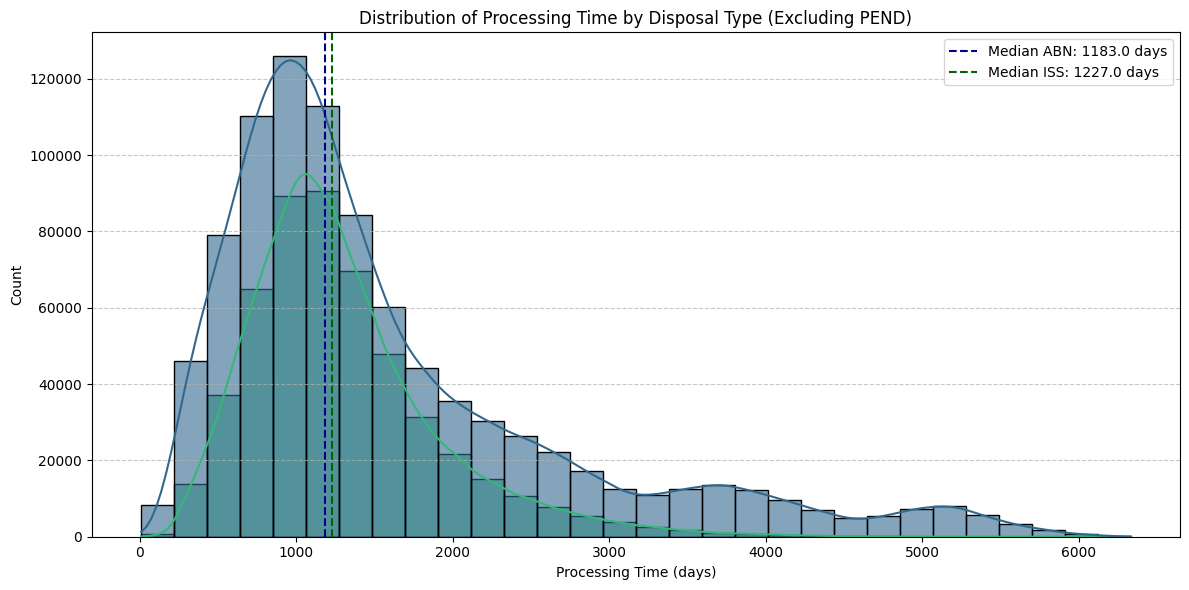

In [15]:
# Filter out PEND disposal type
filtered_data = data[data['app_disposal_type'] != 'PEND']

# Create a figure for the distribution plot
plt.figure(figsize=(12, 6))

# Plot the distribution of processing time by disposal type
sns.histplot(data=filtered_data, x='processing_time', hue='app_disposal_type', 
             kde=True, bins=30, alpha=0.6, palette='viridis')

plt.title('Distribution of Processing Time by Disposal Type (Excluding PEND)')
plt.xlabel('Processing Time (days)')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Disposal Type')

# Add vertical lines for mean processing time
for disposal_type, color in zip(['ABN', 'ISS'], ['darkblue', 'darkgreen']):
    mean_time = filtered_data[filtered_data['app_disposal_type'] == disposal_type]['processing_time'].median()
    plt.axvline(x=mean_time, color=color, linestyle='--', 
                label=f'Median {disposal_type}: {mean_time:.1f} days')

plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Create a boxplot to compare processing time across different workgroups, excluding PEND
plt.figure(figsize=(12, 6))

# Filter out PEND disposal type
no_pend_data = filtered_data

# Create the boxplot by workgroup (au)
sns.boxplot(x='workgroup', y='processing_time', data=no_pend_data, palette='viridis')

# Add title and labels
plt.title('Processing Time by Workgroup (Excluding PEND)')
plt.xlabel('Workgroup (workgroup)')
plt.ylabel('Processing Time (days)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Calculate and add mean markers
means_by_au = no_pend_data.groupby('workgroup')['processing_time'].mean()
for i, au in enumerate(means_by_au.index):
    plt.plot(i, means_by_au[au], 'o', color='red', markersize=8, 
             markeredgecolor='black', markeredgewidth=1.5, 
             label='Mean' if i==0 else '')

plt.legend()
plt.tight_layout()
plt.show()

C:\Users\felix\AppData\Local\Temp\ipykernel_424\1308413019.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='workgroup', y='processing_time', data=no_pend_data, palette='viridis')


Overall median processing time: 1208.0 days


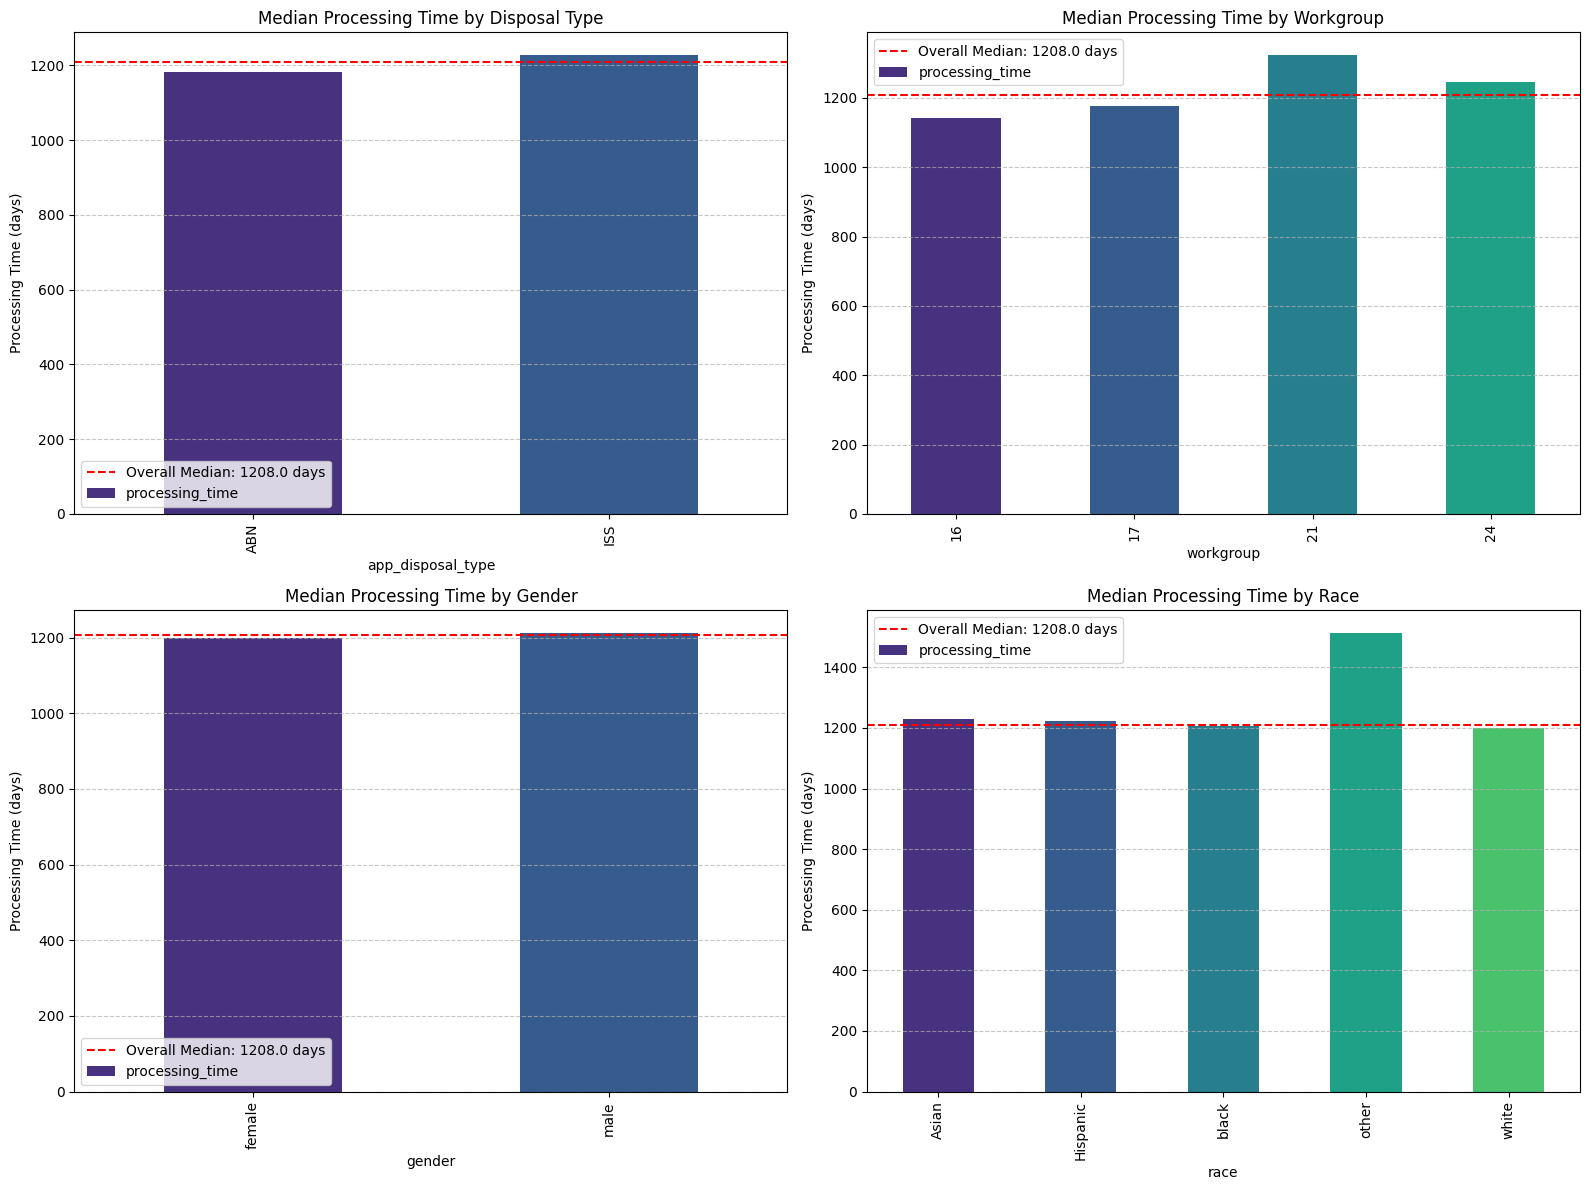

Overall median processing time: 1208.0 days

Median processing time by disposal type:
app_disposal_type
ABN    1183.0
ISS    1227.0
Name: processing_time, dtype: float64

Median processing time by workgroup:
workgroup
16    1141.0
17    1176.0
21    1323.0
24    1247.0
Name: processing_time, dtype: float64

Median processing time by gender:
gender
female    1198.0
male      1212.0
Name: processing_time, dtype: float64

Median processing time by race:
race
Asian       1229.0
Hispanic    1223.0
black       1205.0
other       1513.0
white       1199.0
Name: processing_time, dtype: float64


In [17]:
# Calculate median processing time overall
overall_median = data['processing_time'].median()
print(f"Overall median processing time: {overall_median} days")

# Calculate median processing time by disposal type
disposal_median = data.groupby('app_disposal_type')['processing_time'].median()

# Calculate median processing time by workgroup
workgroup_median = data.groupby('workgroup')['processing_time'].median()

# Calculate median processing time by gender
gender_median = data.groupby('gender')['processing_time'].median()

# Calculate median processing time by race
race_median = data.groupby('race')['processing_time'].median()

# Create a figure to display all median comparisons
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot median by disposal type
disposal_median.plot(kind='bar', ax=axes[0, 0], color=sns.color_palette("viridis"))
axes[0, 0].set_title('Median Processing Time by Disposal Type')
axes[0, 0].set_ylabel('Processing Time (days)')
axes[0, 0].axhline(y=overall_median, color='r', linestyle='--', label=f'Overall Median: {overall_median} days')
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0, 0].legend()

# Plot median by workgroup
workgroup_median.plot(kind='bar', ax=axes[0, 1], color=sns.color_palette("viridis"))
axes[0, 1].set_title('Median Processing Time by Workgroup')
axes[0, 1].set_ylabel('Processing Time (days)')
axes[0, 1].axhline(y=overall_median, color='r', linestyle='--', label=f'Overall Median: {overall_median} days')
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
axes[0, 1].legend()

# Plot median by gender
gender_median.plot(kind='bar', ax=axes[1, 0], color=sns.color_palette("viridis"))
axes[1, 0].set_title('Median Processing Time by Gender')
axes[1, 0].set_ylabel('Processing Time (days)')
axes[1, 0].axhline(y=overall_median, color='r', linestyle='--', label=f'Overall Median: {overall_median} days')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
axes[1, 0].legend()

# Plot median by race
race_median.plot(kind='bar', ax=axes[1, 1], color=sns.color_palette("viridis"))
axes[1, 1].set_title('Median Processing Time by Race')
axes[1, 1].set_ylabel('Processing Time (days)')
axes[1, 1].axhline(y=overall_median, color='r', linestyle='--', label=f'Overall Median: {overall_median} days')
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Print the numerical results
print(f"Overall median processing time: {overall_median} days")
print("\nMedian processing time by disposal type:")
print(disposal_median)
print("\nMedian processing time by workgroup:")
print(workgroup_median)
print("\nMedian processing time by gender:")
print(gender_median)
print("\nMedian processing time by race:")
print(race_median)

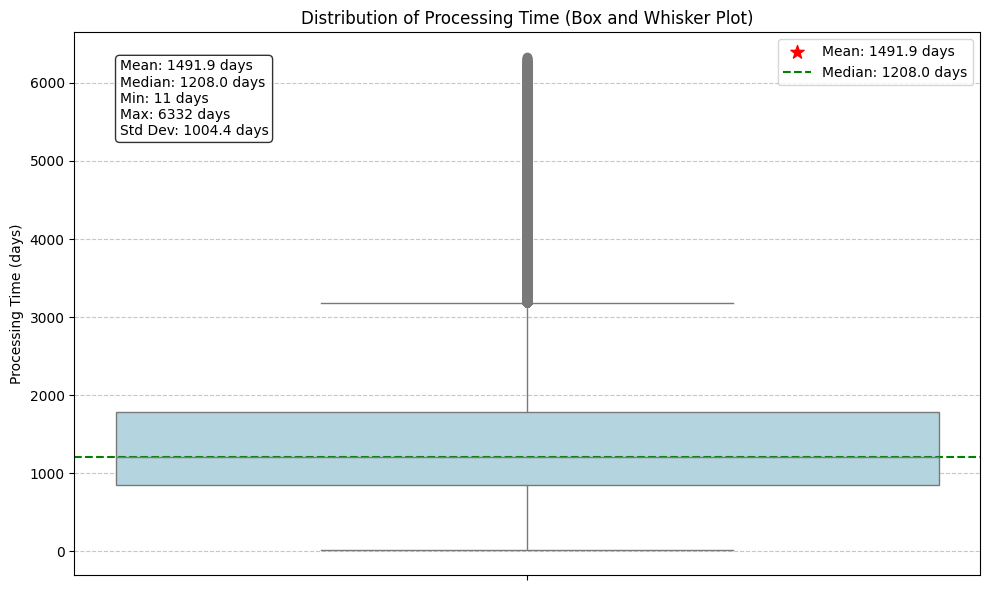

Mean processing time: 1491.9 days
Median processing time: 1208.0 days


In [18]:
# Create a boxplot to show the distribution of processing time
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(y='processing_time', data=data, color='lightblue')

# Add points for the mean
mean_processing_time = data['processing_time'].mean()
plt.scatter(0, mean_processing_time, color='red', s=100, marker='*', label=f'Mean: {mean_processing_time:.1f} days')

# Add the median as a line
median_processing_time = data['processing_time'].median()
plt.axhline(y=median_processing_time, color='green', linestyle='--', label=f'Median: {median_processing_time:.1f} days')

# Add labels and title
plt.title('Distribution of Processing Time (Box and Whisker Plot)')
plt.ylabel('Processing Time (days)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Add statistics text box
stats_text = (f"Mean: {mean_processing_time:.1f} days\n"
              f"Median: {median_processing_time:.1f} days\n"
              f"Min: {data['processing_time'].min()} days\n"
              f"Max: {data['processing_time'].max()} days\n"
              f"Std Dev: {data['processing_time'].std():.1f} days")

plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Mean processing time: {mean_processing_time:.1f} days")
print(f"Median processing time: {median_processing_time:.1f} days")

Proportion of app_disposal_type for each examiner_id:


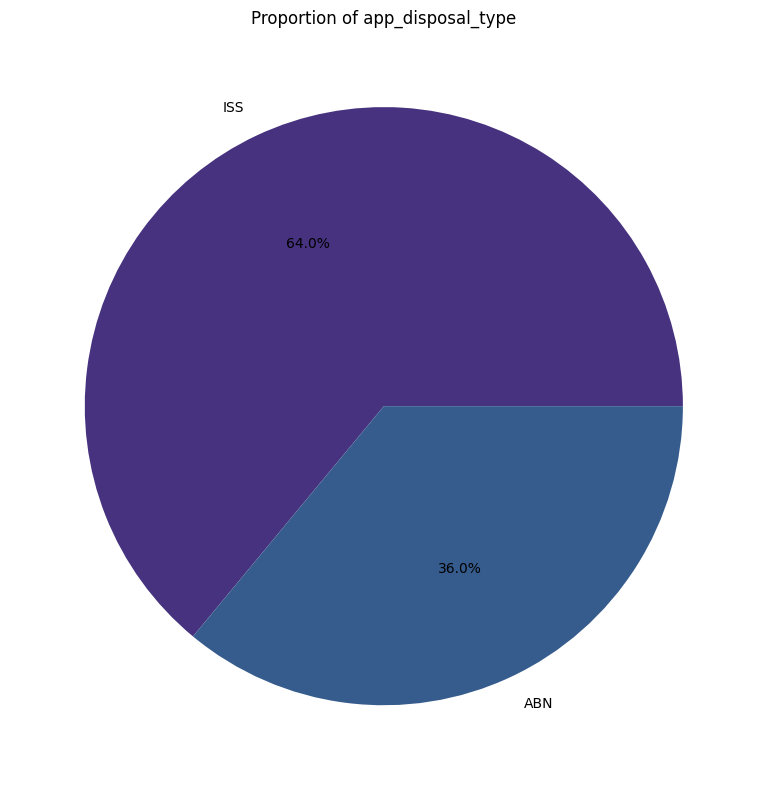

In [19]:
# Group by examiner_id and calculate disposal type proportions
examiner_disposal = data.groupby(['examiner_id', 'app_disposal_type']).size().unstack(fill_value=0)

# Calculate the proportion for each examiner
examiner_disposal_prop = examiner_disposal.div(examiner_disposal.sum(axis=1), axis=0)

# Display the result
print("Proportion of app_disposal_type for each examiner_id:")
examiner_disposal_prop

# Plot the overall distribution of app_disposal_type in the dataset
plt.figure(figsize=(10, 6))
disposal_counts = data['app_disposal_type'].value_counts()
disposal_counts.plot(kind='bar', color=sns.color_palette("viridis"))
plt.title('Distribution of app_disposal_type')
plt.xlabel('Disposal Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pie chart of app_disposal_type distribution
plt.figure(figsize=(8, 8))
disposal_counts.plot(kind='pie', autopct='%1.1f%%', colors=sns.color_palette("viridis"))
plt.title('Proportion of app_disposal_type')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [20]:
# Create a boxplot to compare processing time across different app_disposal_types
plt.figure(figsize=(12, 6))
sns.boxplot(x='app_disposal_type', y='processing_time', data=data, palette='viridis')
plt.title('Processing Time by Application Disposal Type')
plt.xlabel('Disposal Type')
plt.ylabel('Processing Time (days)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add mean markers
means = data.groupby('app_disposal_type')['processing_time'].mean()
for i, disposal_type in enumerate(means.index):
    plt.plot(i, means[disposal_type], 'o', color='red', markersize=8, 
             markeredgecolor='black', markeredgewidth=1.5, label='Mean' if i==0 else '')

plt.legend()
plt.tight_layout()
plt.show()

# Display summary statistics for processing time by disposal type
print("Summary Statistics for Processing Time by Disposal Type:")
processing_time_stats = data.groupby('app_disposal_type')['processing_time'].describe()
processing_time_stats





C:\Users\felix\AppData\Local\Temp\ipykernel_424\4008464978.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='app_disposal_type', y='processing_time', data=data, palette='viridis')


Summary Statistics for Processing Time by Disposal Type:


count         mean          std   min    25%     50%  \
app_disposal_type                                                            
ABN                516650.0  1296.349039   611.831315  11.0  887.0  1183.0   
ISS                917885.0  1601.899190  1154.215083  14.0  828.0  1227.0   

                      75%     max  
app_disposal_type                  
ABN                1569.0  5951.0  
ISS                2004.0  6332.0

In [21]:
# Create a new column indicating if processing time is under 365 days then became 1209 days

data['under_365_days'] = data['processing_time'] < 1209
# Calculate the portion of applications approved/rejected under 365 days by disposal type
under_365_by_type = data.groupby(['app_disposal_type', 'under_365_days']).size().unstack(fill_value=0)
under_365_by_type_percent = under_365_by_type.div(under_365_by_type.sum(axis=1), axis=0) * 100

# Display results
print("Percentage of applications processed under 365 days by disposal type:")
print(under_365_by_type_percent[True].round(2), "% of applications")

# Create a grouped bar chart to visualize the results
plt.figure(figsize=(10, 6))
under_365_by_type.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title('Number of Applications by Processing Time (1209 days threshold)')
plt.xlabel('Disposal Type')
plt.ylabel('Number of Applications')
plt.legend(['Over 1209 days', 'Under 1209 days'])
plt.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for i, disposal_type in enumerate(under_365_by_type.index):
    for j, status in enumerate([False, True]):
        if status in under_365_by_type.columns:
            count = under_365_by_type.iloc[i, j]
            percentage = under_365_by_type_percent.iloc[i, j]
            plt.text(i + (j-0.5)/2, count/2, f'{percentage:.1f}%', 
                    ha='center', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

Percentage of applications processed under 365 days by disposal type:
app_disposal_type
ABN    52.04
ISS    48.89
Name: True, dtype: float64 % of applications


<Figure size 1000x600 with 0 Axes>

In [22]:
# Create a stacked bar chart for examiners' disposal type proportions
plt.figure(figsize=(14, 8))

# Select a subset of examiners to make the plot readable (first 20)
sample_examiners = examiner_disposal_prop.iloc[:20]

# Plot the stacked bar chart
sample_examiners.plot(kind='bar', stacked=True, colormap='viridis', figsize=(14, 8))
plt.title('Proportion of Disposal Types by Examiner (Sample of First 20 Examiners)')
plt.xlabel('Examiner ID')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Disposal Type')
plt.tight_layout()
plt.show()

# Create a heatmap to visualize the distribution of disposal types across all examiners
plt.figure(figsize=(12, 10))
# Sort examiners by the proportion of ISS (or any other category you want to emphasize)
sorted_examiners = examiner_disposal_prop.sort_values(by=['ISS'], ascending=False)

# Create a heatmap
sns.heatmap(sorted_examiners, cmap='viridis', cbar_kws={'label': 'Proportion'})
plt.title('Heatmap of Disposal Type Proportions by Examiner')
plt.xlabel('Disposal Type')
plt.ylabel('Examiner ID')
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

# Complex Contagion analysis

## Data preperation

### Keep only data of interest

#### Year

In [23]:
# Convert app_last_action_date to datetime if it's not already
data['app_last_action_date'] = pd.to_datetime(data['app_last_action_date'])

# Filter out rows with app_last_action_date past December 31, 2024
cutoff_date = pd.to_datetime('2024-12-31')
filtered_data_2024 = data[data['app_last_action_date'] <= cutoff_date]

# Print information about the filtering
print(f"Original data shape: {data.shape}")
print(f"Data filtered up to Dec 31, 2024 shape: {filtered_data_2024.shape}")
print(f"Number of rows removed: {data.shape[0] - filtered_data_2024.shape[0]}")

# Display the range of dates in the filtered data
print(f"\nDate range in filtered data:")
print(f"Earliest date: {filtered_data_2024['app_last_action_date'].min()}")
print(f"Latest date: {filtered_data_2024['app_last_action_date'].max()}")

# Update the data variable with the filtered data
data = filtered_data_2024



##### ONLY 2008 #########
# Filter data for rows with app_last_action_date in 2008
start_date = pd.to_datetime('2008-01-01')
end_date = pd.to_datetime('2008-12-31')

# Create a copy of the filtered data
data_2008 = data[(data['app_last_action_date'] >= start_date) & 
                 (data['app_last_action_date'] <= end_date)].copy()
data = data_2008.copy()





Original data shape: (1434535, 14)
Data filtered up to Dec 31, 2024 shape: (1434535, 14)
Number of rows removed: 0

Date range in filtered data:
Earliest date: 2000-05-24 00:00:00
Latest date: 2019-11-16 00:00:00


#### Workgroups

In [24]:
# Filter data for workgroups 162 and 164 only
filtered_wg_data = data[data['workgroup'].isin([162, 164])]

# Display basic information about the filtered data
print(f"Original data shape: {data.shape}")
print(f"Data filtered for workgroups 162 and 164: {filtered_wg_data.shape}")

# Calculate some basic statistics for each workgroup
stats_by_wg = filtered_wg_data.groupby('workgroup')['processing_time'].agg(['count', 'mean', 'median', 'std'])
print("\nProcessing time statistics by workgroup:")
print(stats_by_wg)

# Plot the distribution of processing times for each workgroup
plt.figure(figsize=(12, 6))
sns.boxplot(x='workgroup', y='processing_time', data=filtered_wg_data, palette='viridis')
plt.title('Processing Time by Workgroup (162 and 164)')
plt.xlabel('Workgroup')
plt.ylabel('Processing Time (days)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#data = filtered_wg_data.copy()

Original data shape: (63459, 14)
Data filtered for workgroups 162 and 164: (0, 14)

Processing time statistics by workgroup:
Empty DataFrame
Columns: [count, mean, median, std]
Index: []


##  Quarterly Slices & “Fast vs. Slow” Labeling

### Create Quarterly Time Bins

In [25]:

MEDIAN_PT   = 1209                  # days  ⇢ fast/slow split
LOOKBACK_D  = 720                   # rolling window (days)
MIN_OBS     = 1                    # min disposals to label examiner


mediantime = MEDIAN_PT

In [26]:


# Find first and last dates in app_last_action_date
app_last_action_dates = pd.to_datetime(data['app_last_action_date'])
first_date = app_last_action_dates.min()
last_date = app_last_action_dates.max()

print(f"First date in app_last_action_date: {first_date}")
print(f"Last date in app_last_action_date: {last_date}")


start_date = first_date
end_date = last_date
# Generate quarter dates
quarters = pd.date_range(start=start_date, end=end_date, freq='Q')





First date in app_last_action_date: 2008-01-01 00:00:00
Last date in app_last_action_date: 2008-12-31 00:00:00


C:\Users\felix\AppData\Local\Temp\ipykernel_424\3800392072.py:13: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range(start=start_date, end=end_date, freq='Q')


###  Label Each Examiner as Fast or Slow per Quarter

In [27]:


quarterly_labels = []  # store (examiner_id, quarter, label)

for q in quarters:
    # define window start
    window_start = q - pd.Timedelta(days=720)
    
    # filter disposals
    mask = (data['app_last_action_date'] >= window_start) & \
           (data['app_last_action_date'] < q)
    df_window = data[mask]
    
    # group by examiner
    grouped = df_window.groupby('examiner_id')['processing_time']
    
    for examiner_id, times in grouped:
        n_total = times.size
        n_slow = (times > mediantime).sum()
        if n_total == 0:
            continue
        fraction_slow = n_slow / n_total
        label = 'slow' if fraction_slow > 0.5 else 'fast'
        
        quarterly_labels.append((examiner_id, q, label))


labels_df = pd.DataFrame(quarterly_labels, columns=['examiner_id', 'quarter', 'label'])

Overall proportion of examiners:
slow: 68.45%
fast: 31.55%

Number of examiners labeled each quarter:
count       4.000000
mean     1992.250000
std       231.204635
min      1733.000000
25%      1872.500000
50%      1975.000000
75%      2094.750000
max      2286.000000
dtype: float64


<Figure size 1400x800 with 0 Axes>

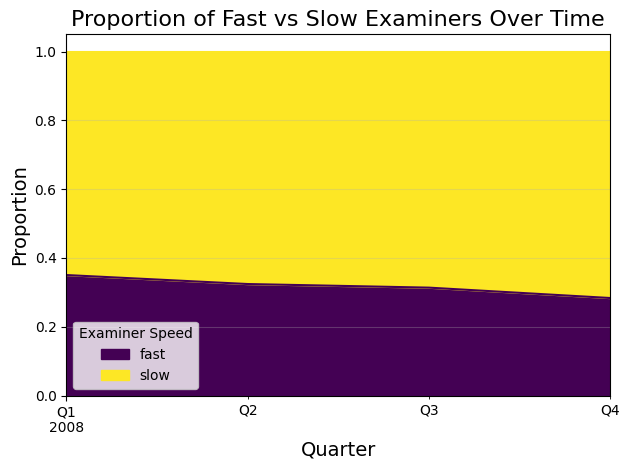

In [28]:
# Count fast and slow labels for each quarter
quarterly_counts = labels_df.groupby(['quarter', 'label']).size().unstack(fill_value=0)

# Calculate proportions
quarterly_proportions = quarterly_counts.div(quarterly_counts.sum(axis=1), axis=0)

# Create a stacked area chart to show proportion over time
plt.figure(figsize=(14, 8))
quarterly_proportions.plot(kind='area', stacked=True, colormap='viridis')
plt.title('Proportion of Fast vs Slow Examiners Over Time', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(title='Examiner Speed')
plt.tight_layout()

# Print the overall proportion
total_counts = labels_df['label'].value_counts()
total_proportions = total_counts / total_counts.sum() * 100
print("Overall proportion of examiners:")
for label, proportion in total_proportions.items():
    print(f"{label}: {proportion:.2f}%")

# Print statistics by quarter
print("\nNumber of examiners labeled each quarter:")
print(quarterly_counts.sum(axis=1).describe())

plt.show()

In [29]:
# Convert quarterly_labels into a DataFrame for easier analysis
labels_df = pd.DataFrame(quarterly_labels, columns=['examiner_id', 'quarter', 'label'])

# Count fast and slow labels for each quarter
quarterly_counts = labels_df.groupby(['quarter', 'label']).size().unstack(fill_value=0)

# Create figure for absolute counts
plt.figure(figsize=(14, 8))
quarterly_counts.plot(kind='bar', colormap='viridis')
plt.title('Total Number of Fast vs Slow Examiners Over Time', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Examiner Speed')
plt.tight_layout()
plt.show()



<Figure size 1400x800 with 0 Axes>

## Construct the Quarterly Advice Network


In [30]:
# Get a list of valid examiner_ids from the data
valid_examiner_ids = data['examiner_id'].unique()

# Filter edges to only keep those where both examiners are in our dataset
filtered_edges = edges[
    (edges['ego_examiner_id'].isin(valid_examiner_ids)) | 
    (edges['alter_examiner_id'].isin(valid_examiner_ids))
]

# Print information about the filtering
print(f"Original edges shape: {edges.shape}")
print(f"Filtered edges shape: {filtered_edges.shape}")
print(f"Number of edges removed: {edges.shape[0] - filtered_edges.shape[0]}")

# Update the edges variable
edges = filtered_edges

# Verify the filtering worked
print("\nVerifying examiners in edges exist in data:")
ego_in_data = edges['ego_examiner_id'].isin(valid_examiner_ids).mean() * 100
alter_in_data = edges['alter_examiner_id'].isin(valid_examiner_ids).mean() * 100
print(f"Percentage of ego examiners in data: {ego_in_data:.2f}%")
print(f"Percentage of alter examiners in data: {alter_in_data:.2f}%")



# Find first and last dates in app_last_action_date
edge_last_action_dates = pd.to_datetime(edges['advice_date'])
first_date = edge_last_action_dates.min()
last_date = edge_last_action_dates.max()

print(f"First date in edges: {first_date}")
print(f"Last date in edges: {last_date}")

Original edges shape: (27771, 4)
Filtered edges shape: (21239, 4)
Number of edges removed: 6532

Verifying examiners in edges exist in data:
Percentage of ego examiners in data: 76.61%
Percentage of alter examiners in data: 57.79%
First date in edges: 2008-01-02 00:00:00
Last date in edges: 2008-12-31 00:00:00


In [31]:
# Plot frequency of advice dates
plt.figure(figsize=(14, 8))

# Create a histogram of advice dates
edges['advice_date'].hist(bins=50, color='steelblue', alpha=0.7, edgecolor='black')

# Add a kde line to show the distribution
sns.kdeplot(edges['advice_date'], color='darkred', linewidth=2)

# Format the plot
plt.title('Distribution of Advice Interactions Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add vertical lines for years
years = pd.date_range(start=edges['advice_date'].min().year, 
                     end=edges['advice_date'].max().year + 1, 
                     freq='YS')
for year in years:
    plt.axvline(x=year, color='gray', linestyle='--', alpha=0.5)

# Add some statistics as a text box
stats_text = (f"First advice: {edges['advice_date'].min().strftime('%Y-%m-%d')}\n"
              f"Last advice: {edges['advice_date'].max().strftime('%Y-%m-%d')}\n"
              f"Total interactions: {len(edges)}\n"
              f"Peak period: {edges['advice_date'].value_counts().idxmax().strftime('%Y-%m')}")

plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         verticalalignment='top')

plt.tight_layout()
plt.xticks(rotation=45)

(array([    0.,  1826.,  3652.,  5479.,  7305.,  9131., 10957., 12784.,
        14610., 16436.]),
 [Text(0.0, 0, '1970'),
  Text(1826.0, 0, '1975'),
  Text(3652.0, 0, '1980'),
  Text(5479.0, 0, '1985'),
  Text(7305.0, 0, '1990'),
  Text(9131.0, 0, '1995'),
  Text(10957.0, 0, '2000'),
  Text(12784.0, 0, '2005'),
  Text(14610.0, 0, '2010'),
  Text(16436.0, 0, '2015')])

In [32]:

quarterly_networks = {}
graphs = {} 

for q in quarters:
    window_start = q - pd.offsets.QuarterBegin(1)  
    mask_edges = (edges['advice_date'] >= window_start) & \
                 (edges['advice_date'] < q)
    df_edges = edges[mask_edges]
    
    # build  network 
    G = nx.from_pandas_edgelist(df_edges, 
                                source='ego_examiner_id', 
                                target='alter_examiner_id', 
                                create_using=nx.DiGraph())
    quarterly_networks[q] = G
    graphs[q] = G


print(f"Number of quarters: {len(graphs)}")



Number of quarters: 4


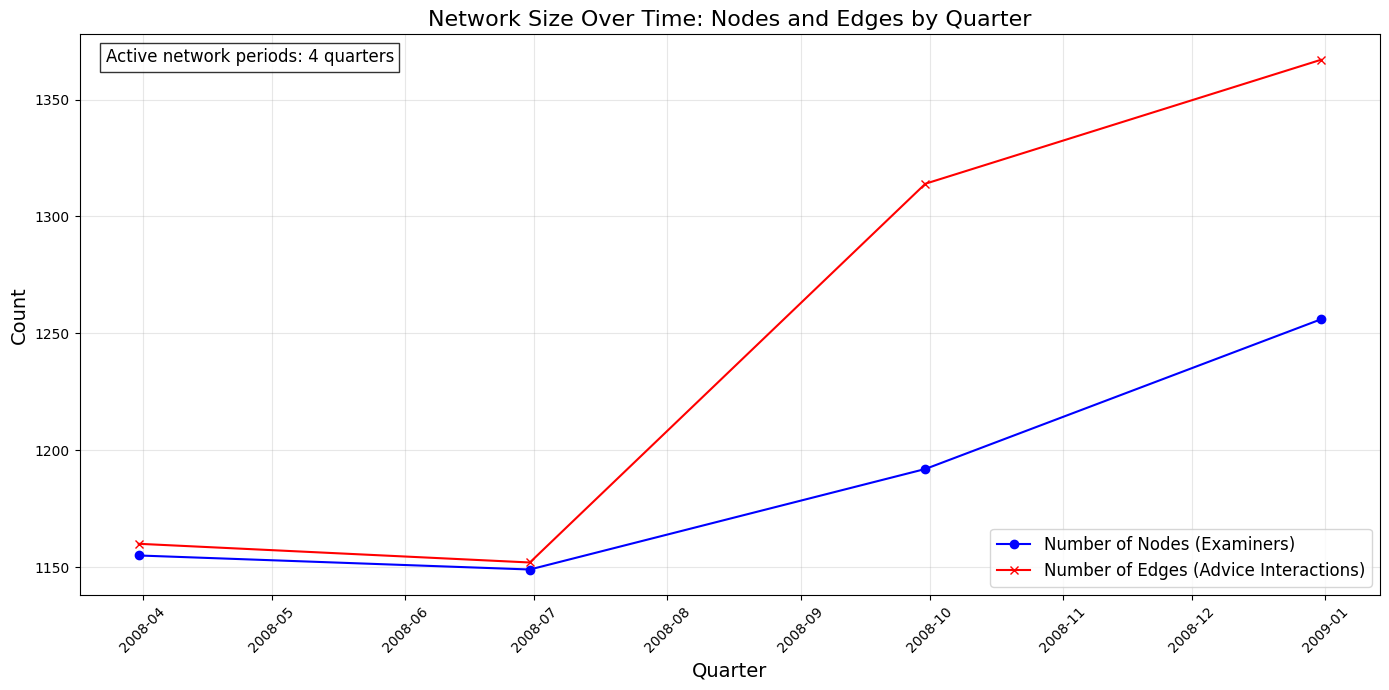

In [33]:
# Extract network size data from quarterly_networks
network_sizes = []

for quarter, network in quarterly_networks.items():
    num_nodes = network.number_of_nodes()
    num_edges = network.number_of_edges()
    
    network_sizes.append({
        'quarter': quarter,
        'nodes': num_nodes,
        'edges': num_edges
    })

# Convert to DataFrame for easier plotting
network_df = pd.DataFrame(network_sizes)

# Sort by quarter
network_df = network_df.sort_values('quarter')

# Create plot
plt.figure(figsize=(14, 7))

# Plot nodes and edges
plt.plot(network_df['quarter'], network_df['nodes'], 'b-', marker='o', label='Number of Nodes (Examiners)')
plt.plot(network_df['quarter'], network_df['edges'], 'r-', marker='x', label='Number of Edges (Advice Interactions)')

# Add labels and title
plt.title('Network Size Over Time: Nodes and Edges by Quarter', fontsize=16)
plt.xlabel('Quarter', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

# Format x-axis with better date labels
plt.xticks(rotation=45)

# Add annotations for quarters with significant activity
active_quarters = network_df[(network_df['nodes'] > 0) | (network_df['edges'] > 0)]
if not active_quarters.empty:
    plt.text(0.02, 0.95, f"Active network periods: {len(active_quarters)} quarters", 
             transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

Visualizing networks for quarters: 2008-03-31 00:00:00, 2008-06-30 00:00:00, 2008-09-30 00:00:00


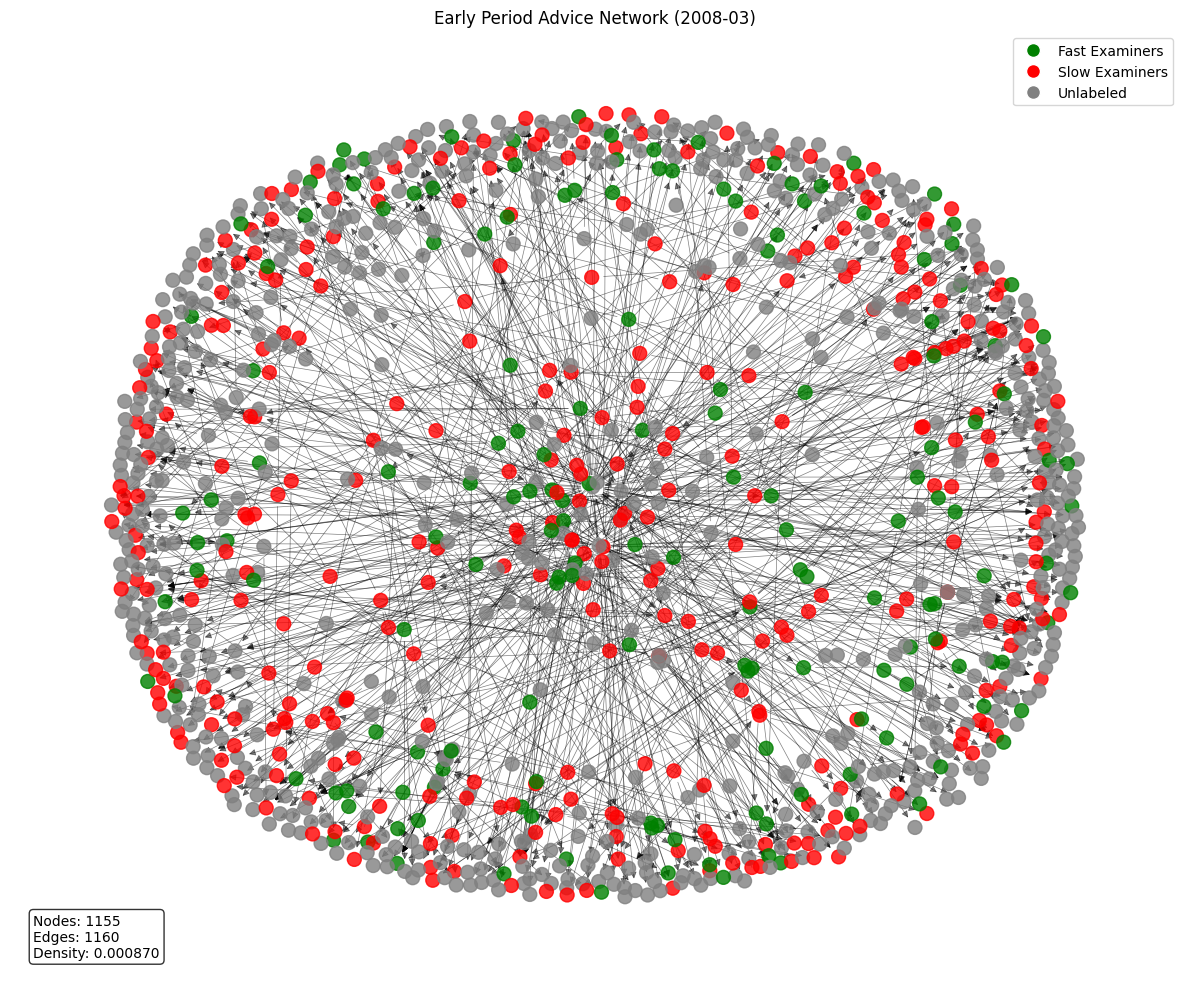

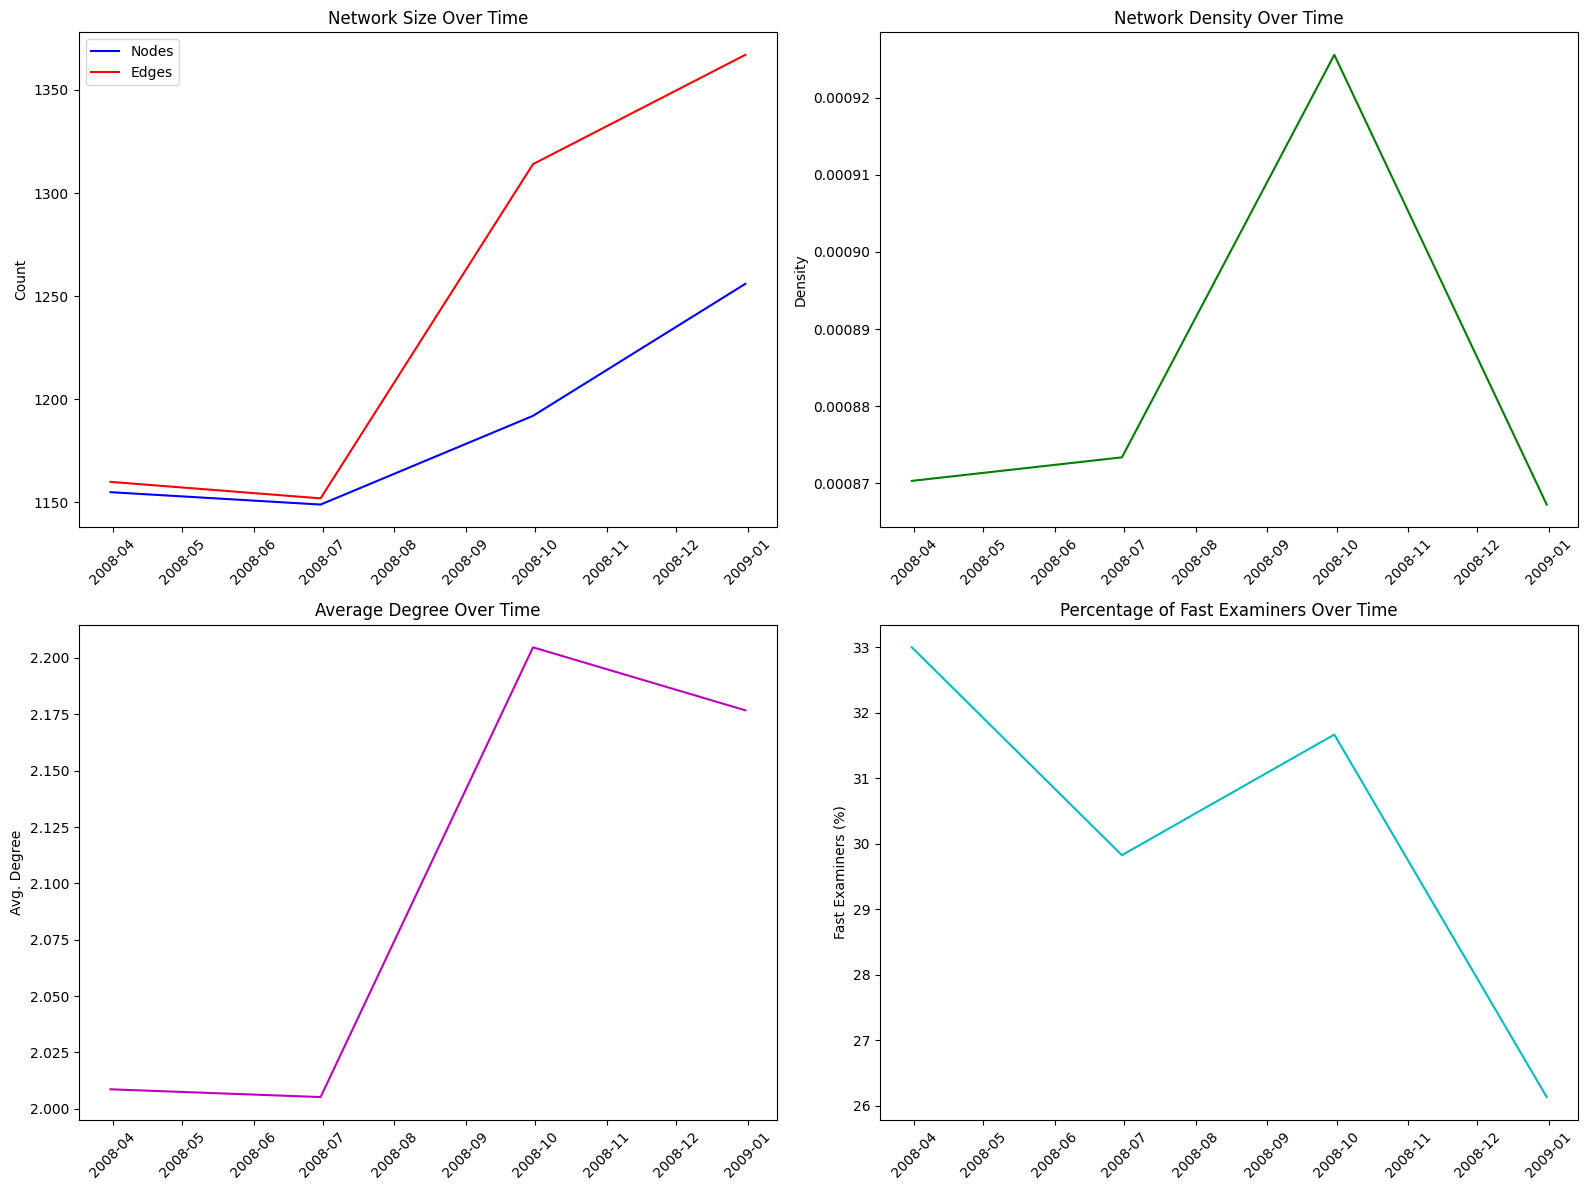

In [34]:
# Function to visualize a network for a given quarter
def visualize_network(quarter_idx, title=None):
    plt.figure(figsize=(12, 10))
    
    # Get the quarter date
    quarter = list(quarterly_networks.keys())[quarter_idx]
    G = quarterly_networks[quarter]
    
    if title is None:
        title = f"Advice Network for Quarter: {quarter.strftime('%Y-%m')}"
    
    # Get labels data for this quarter
    quarter_labels = labels_df[labels_df['quarter'] == quarter]
    
    # Create a mapping of examiner_id to label for this quarter
    labels_dict = dict(zip(quarter_labels['examiner_id'], quarter_labels['label']))
    
    # Assign node colors based on fast/slow labels
    node_colors = []
    for node in G.nodes():
        if node in labels_dict:
            node_colors.append('green' if labels_dict[node] == 'fast' else 'red')
        else:
            node_colors.append('gray')  # No label
    
    # Calculate network metrics
    density = nx.density(G)
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    
    # Use a layout that spreads nodes nicely
    pos = nx.spring_layout(G, seed=42)  # Fixed seed for reproducibility
    
    # Draw the network
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, arrows=True, arrowsize=10)
    
    # Add a legend
    fast_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Fast Examiners')
    slow_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Slow Examiners')
    unlabeled_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Unlabeled')
    plt.legend(handles=[fast_patch, slow_patch, unlabeled_patch], loc='upper right')
    
    # Add network statistics as text
    stats_text = f"Nodes: {num_nodes}\nEdges: {num_edges}\nDensity: {density:.6f}"
    plt.text(0.02, 0.02, stats_text, transform=plt.gca().transAxes, 
            verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return G

# Visualize network for a few different quarters (early, middle, late)
# early_quarter_idx = 4    # 2001-09-30
# mid_quarter_idx = len(quarterly_networks) // 2  # Middle quarter
# late_quarter_idx = len(quarterly_networks) - 5  # Near the end

# early_quarter_idx = 31
# mid_quarter_idx = 32  
# late_quarter_idx = 33 

early_quarter_idx = 0
mid_quarter_idx = 1
late_quarter_idx = 2 

print(f"Visualizing networks for quarters: {list(quarterly_networks.keys())[early_quarter_idx]}, "
      f"{list(quarterly_networks.keys())[mid_quarter_idx]}, "
      f"{list(quarterly_networks.keys())[late_quarter_idx]}")

# Visualize the networks
early_G = visualize_network(early_quarter_idx, f"Early Period Advice Network ({list(quarterly_networks.keys())[early_quarter_idx].strftime('%Y-%m')})")
mid_G = visualize_network(mid_quarter_idx, f"Mid Period Advice Network ({list(quarterly_networks.keys())[mid_quarter_idx].strftime('%Y-%m')})")
late_G = visualize_network(late_quarter_idx, f"Late Period Advice Network ({list(quarterly_networks.keys())[late_quarter_idx].strftime('%Y-%m')})")

# Analyze network evolution over time
network_stats = []
for quarter, G in quarterly_networks.items():
    # Calculate proportion of fast/slow examiners in the network
    quarter_labels = labels_df[labels_df['quarter'] == quarter]
    labels_dict = dict(zip(quarter_labels['examiner_id'], quarter_labels['label']))
    
    nodes_in_network = set(G.nodes())
    labeled_nodes = set(nodes_in_network).intersection(set(labels_dict.keys()))
    
    fast_count = sum(1 for node in labeled_nodes if labels_dict[node] == 'fast')
    slow_count = sum(1 for node in labeled_nodes if labels_dict[node] == 'slow')
    
    fast_pct = fast_count / max(len(labeled_nodes), 1) * 100 if labeled_nodes else 0
    
    # Calculate network metrics
    density = nx.density(G)
    avg_degree = sum(dict(G.degree()).values()) / max(G.number_of_nodes(), 1)
    
    network_stats.append({
        'quarter': quarter,
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': density,
        'avg_degree': avg_degree,
        'labeled_nodes': len(labeled_nodes),
        'fast_pct': fast_pct
    })

# Convert to DataFrame and analyze trends
stats_df = pd.DataFrame(network_stats)

# Plot network metrics over time
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Network size over time
axes[0, 0].plot(stats_df['quarter'], stats_df['nodes'], 'b-', label='Nodes')
axes[0, 0].plot(stats_df['quarter'], stats_df['edges'], 'r-', label='Edges')
axes[0, 0].set_title('Network Size Over Time')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Network density over time
axes[0, 1].plot(stats_df['quarter'], stats_df['density'], 'g-')
axes[0, 1].set_title('Network Density Over Time')
axes[0, 1].set_ylabel('Density')
axes[0, 1].tick_params(axis='x', rotation=45)

# Average degree over time
axes[1, 0].plot(stats_df['quarter'], stats_df['avg_degree'], 'm-')
axes[1, 0].set_title('Average Degree Over Time')
axes[1, 0].set_ylabel('Avg. Degree')
axes[1, 0].tick_params(axis='x', rotation=45)

# Fast examiner percentage over time
axes[1, 1].plot(stats_df['quarter'], stats_df['fast_pct'], 'c-')
axes[1, 1].set_title('Percentage of Fast Examiners Over Time')
axes[1, 1].set_ylabel('Fast Examiners (%)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Complex Contagion: Threshold Simulation

## Version 1

In [35]:

# ensure integer IDs
for col in ['examiner_id', 'ego_examiner_id', 'alter_examiner_id']:
    if col in edges:
        edges[col] = edges[col].astype('int64', errors='ignore')
    if col in data_no_pend:
        data[col]  = data[col].astype('int64', errors='ignore')




# Quarter grid
q_start = data['app_last_action_date'].min().to_period('Q').start_time
q_end   = data['app_last_action_date'].max().to_period('Q').end_time
quarters = pd.date_range(q_start, q_end, freq='Q')





C:\Users\felix\AppData\Local\Temp\ipykernel_424\87745896.py:14: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters = pd.date_range(q_start, q_end, freq='Q')


In [36]:
# 7.  Helper: neighbour fast fraction
def frac_fast(node: int, G: nx.Graph, fast_set: set[int]) -> float:
    nbrs = set(G.successors(node)) if isinstance(G, nx.DiGraph) else set(G[node])
    if not nbrs:
        return 0.0
    return len(nbrs & fast_set) / len(nbrs)

# 8.  Simulation for a given threshold θ
def simulate(theta: float) -> dict[pd.Timestamp, set[int]]:
    """Return dict quarter -> fast_set under fraction threshold theta."""
    q_sorted = sorted(graphs.keys())
    first_q  = q_sorted[0]
    init_set = set(labels_df.loc[
        (labels_df['quarter'] == first_q) & (labels_df['label']=='fast'),
        'examiner_id'])
    fast_sets = {first_q: init_set}

    for q_prev, q_curr in zip(q_sorted[:-1], q_sorted[1:]):
        G = graphs[q_curr]
        current_fast = set(fast_sets[q_prev])

        for n in G.nodes:
            if n in current_fast:
                continue
            if frac_fast(n, G, current_fast) >= theta:
                current_fast.add(n)

        fast_sets[q_curr] = current_fast
    return fast_sets

# 9.  Evaluation metric (mean Jaccard)
def jaccard(a: set, b: set) -> float:
    return 1.0 if (not a and not b) else len(a & b) / len(a | b)

def mean_jaccard(pred_sets: dict) -> float:
    sims = []
    for q, pred in pred_sets.items():
        real = set(labels_df.loc[
            (labels_df['quarter']==q) & (labels_df['label']=='fast'),
            'examiner_id'])
        sims.append(jaccard(pred, real))
    return float(np.mean(sims))

# 10.  Grid‑search threshold θ
grid = np.round(np.arange(0.05, 0.55, 0.05), 2)
scores = []

for θ in grid:
    pred = simulate(θ)
    scores.append({'theta': θ, 'mean_jaccard': mean_jaccard(pred)})

results = (pd.DataFrame(scores)
           .sort_values('mean_jaccard', ascending=False)
           .reset_index(drop=True))

print("\n===  GRID‑SEARCH RESULTS  ===")
print(results)

best_theta = results.iloc[0]['theta']
print(f"\nBest‑fit threshold θ*  = {best_theta:.2f} "
      f"(mean Jaccard ≈ {results.iloc[0]['mean_jaccard']:.3f})")


===  GRID‑SEARCH RESULTS  ===
   theta  mean_jaccard
0   0.50      0.663207
1   0.45      0.663207
2   0.40      0.662226
3   0.35      0.662106
4   0.30      0.655435
5   0.25      0.654009
6   0.20      0.647763
7   0.15      0.644885
8   0.10      0.644683
9   0.05      0.644344

Best‑fit threshold θ*  = 0.50 (mean Jaccard ≈ 0.663)


- **Consistent Performance for Low Thresholds**: The mean Jaccard similarity remains constant at 0.733201 for threshold values (θ) from 0.05 to 0.25, indicating that the model's predictions are robust within this range.
- **Slight Decrease for Higher Thresholds**: As θ increases beyond 0.25, the mean Jaccard similarity slightly decreases, suggesting that higher thresholds may exclude some nodes that should be classified as "fast."
- **Optimal Threshold**: The best-fit threshold θ* is identified as 0.05, but any threshold between 0.05 and 0.25 yields the same performance, indicating model robustness.
- **Saturation of "Fast" Nodes**: The set of "fast" nodes may quickly saturate as the threshold increases from 0.05 to 0.25, leading to consistent predictions regardless of the exact threshold value.
- **Graph Structure and Data Characteristics**: The structure of the graph, initialization and propagation rules, and data characteristics contribute to the stability of predictions across different thresholds.


- **Structure of the Graph**
  - **Description**: The connectivity and topology of the graph influence how the "fast" label propagates. Densely connected graphs facilitate rapid spreading of the "fast" label.
  - **Impact**: In a densely connected graph, even a low threshold can capture most "fast" nodes due to high interconnectivity. This makes the model less sensitive to threshold changes.

- **Characteristics of the Data**
  - **Description**: Inherent data characteristics, such as the distribution of node degrees and connectivity patterns, influence the stability of predictions.
  - **Impact**: Data with strong patterns (e.g., high node degrees, clustered connectivity) facilitate consistent spreading of the "fast" label, making the model robust to threshold variations.


However this still does not give string insight into the question **"What is the role of network structure in making examiners faster?"**

## Version 2

In [37]:
# 5. Compute neighbor stats (lagged)
def fast_neighbors_frac(node, G, fast_set):
    # use both in- and out- neighbors for influence
    nbrs = set(G.successors(node)) | set(G.predecessors(node))
    if not nbrs:
        return 0.0
    return len(nbrs & fast_set) / len(nbrs)

lags = []
for q_prev, q_curr in zip(quarters[:-1], quarters[1:]):
    fast_prev = set(labels_df[(labels_df['quarter']==q_prev) &
                              (labels_df['label']=='fast')]['examiner_id'])
    G = graphs[q_curr]
    for e in G.nodes():
        frac = fast_neighbors_frac(e, G, fast_prev)
        deg  = len(set(G.successors(e)) | set(G.predecessors(e)))
        lags.append((e, q_curr, frac, deg))

neigh_df = pd.DataFrame(lags, columns=['examiner_id','quarter',
                                       'fast_frac_prev','deg_prev'])

# Merge neighbor stats into panel
panel = labels_df.merge(neigh_df, on=['examiner_id','quarter'], how='left')
panel = panel.sort_values(['examiner_id','quarter'])


# 6. Compute adoption events
panel['prev_label'] = panel.groupby('examiner_id')['label'].shift(1)
panel['adopted'] = ((panel['prev_label']=='slow') &
                    (panel['label']=='fast')).astype(int)
panel = panel.dropna(subset=['fast_frac_prev'])  # only quarters with neighbor info

# 7. Simulation: grid-search threshold
def simulate(theta):
    q_sorted = sorted(graphs.keys())
    first_q  = q_sorted[0]
    fast_sets = {}
    init_fast = set(labels_df[(labels_df['quarter']==first_q) &
                              (labels_df['label']=='fast')]['examiner_id'])
    fast_sets[first_q] = init_fast.copy()
    for q_prev, q_curr in zip(q_sorted[:-1], q_sorted[1:]):
        current = fast_sets[q_prev].copy()
        G = graphs[q_curr]
        for n in G.nodes():
            if n in current:
                continue
            if fast_neighbors_frac(n, G, current) >= theta:
                current.add(n)
        fast_sets[q_curr] = current
    return fast_sets

def jaccard(a,b):
    return 1.0 if (not a and not b) else len(a&b)/len(a|b)

def mean_jaccard(sim_sets):
    sims = []
    for q, sim in sim_sets.items():
        real = set(labels_df[(labels_df['quarter']==q) &
                             (labels_df['label']=='fast')]['examiner_id'])
        sims.append(jaccard(sim, real))
    return np.mean(sims)

results = []
for theta in np.arange(0.05,0.55,0.05):
    sim_sets = simulate(theta)
    score = mean_jaccard(sim_sets)
    results.append((theta, score))
res_df = pd.DataFrame(results, columns=['theta','mean_jaccard']) \
           .sort_values('mean_jaccard',ascending=False)
print("Threshold results:\n", res_df.head(10))




Threshold results:
    theta  mean_jaccard
9   0.50      0.567293
8   0.45      0.567293
7   0.40      0.560818
6   0.35      0.554965
5   0.30      0.533325
4   0.25      0.507611
3   0.20      0.501371
2   0.15      0.495362
1   0.10      0.489366
0   0.05      0.484176


In [38]:
demo = (
    data[['examiner_id','race','gender','examiner_earliest_date','workgroup']]
    .drop_duplicates('examiner_id')
    .set_index('examiner_id')
)
panel = panel.join(demo, on='examiner_id', how='left')

panel['tenure_days'] = (panel['quarter'] - panel['examiner_earliest_date']).dt.days
panel['tenure_norm'] = (panel['tenure_days'] / 365).pipe(
    lambda s: (s - s.min()) / (s.max() - s.min())
)

# 8.3 Normalize 
panel['deg_prev_norm'] = panel['deg_prev'] / panel['deg_prev'].max()
panel['female'] = (panel['gender'] == 'female').astype(int)
panel['white'] = (panel['race'] == 'white').astype(int)
panel['wg_16'] = (panel['workgroup'] == 16).astype(int)
panel_norm = panel.drop(columns=[
    'deg_prev','tenure_days','race','gender','workgroup','examiner_earliest_date'
]).dropna(subset=[
    'fast_frac_prev','deg_prev_norm','tenure_norm','female','white','wg_16'
])

# Check for multicollinearity
y, X = dmatrices('adopted ~ fast_frac_prev + deg_prev_norm + tenure_norm + female + white + wg_16 + quarter', data=panel_norm, return_type='dataframe')
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

# 9. Run logistic regression with simplified controls
formula = (
    'adopted ~ fast_frac_prev + deg_prev_norm + tenure_norm + '
    'female + white + wg_16 + quarter'
)

                                       feature        VIF
0                                    Intercept  18.548066
1  quarter[T.Timestamp('2008-09-30 00:00:00')]   1.443477
2  quarter[T.Timestamp('2008-12-31 00:00:00')]   1.451008
3                               fast_frac_prev   1.023794
4                                deg_prev_norm   1.007543
5                                  tenure_norm   1.038650
6                                       female   1.030414
7                                        white   1.026937
8                                        wg_16   1.068897


In [39]:



model = smf.logit(formula, data=panel_norm).fit(disp=False)
print(model.summary())

# 10. T‑test on exposure
adopters     = panel_norm[panel_norm['adopted']==1]['fast_frac_prev']
non_adopters = panel_norm[panel_norm['adopted']==0]['fast_frac_prev']
tstat, pval  = ttest_ind(adopters, non_adopters, equal_var=False)
print(f"T‑test: adopters mean={adopters.mean():.3f}, "
      f"non={non_adopters.mean():.3f}, p={pval:.3f}")


                           Logit Regression Results                           
Dep. Variable:                adopted   No. Observations:                 1831
Model:                          Logit   Df Residuals:                     1822
Method:                           MLE   Df Model:                            8
Date:                Tue, 22 Apr 2025   Pseudo R-squ.:                 0.02432
Time:                        15:30:16   Log-Likelihood:                -184.11
converged:                       True   LL-Null:                       -188.69
Covariance Type:            nonrobust   LLR p-value:                    0.3275
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      -3.4772      0.683     -5.089      0.000      -4.816      -2.138
quarter[T.Timestamp('2008-09-30 

Weighted adoption rate (treated): 0.029
Weighted adoption rate (control): 0.020
ATE (treated − control): 0.009


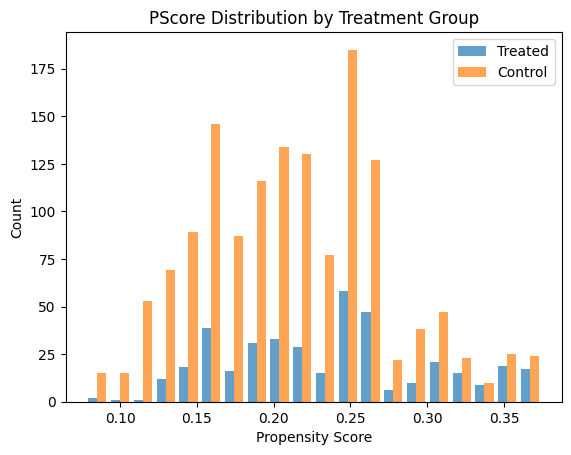

In [40]:


THRESH = 0.30





panel_norm['treated'] = (panel_norm['fast_frac_prev'] >= THRESH).astype(int)

# 2. Fit propensity model: P(treated | covariates)
covariates = ['deg_prev_norm','tenure_norm','female','white','wg_16']
X = panel_norm[covariates]
y = panel_norm['treated']

ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, y)
panel_norm['pscore'] = ps_model.predict_proba(X)[:,1]

# 3. Compute IPTW weights
panel_norm['iptw'] = np.where(
    panel_norm['treated']==1,
    1.0 / panel_norm['pscore'],
    1.0 / (1.0 - panel_norm['pscore'])
)

# 4. Estimate weighted adoption rates and ATE
treated   = panel_norm[panel_norm['treated']==1]
control   = panel_norm[panel_norm['treated']==0]

# Weighted means
mean_treated = np.average(treated['adopted'], weights=treated['iptw'])
mean_control = np.average(control['adopted'], weights=control['iptw'])
ATE = mean_treated - mean_control

print(f"Weighted adoption rate (treated): {mean_treated:.3f}")
print(f"Weighted adoption rate (control): {mean_control:.3f}")
print(f"ATE (treated − control): {ATE:.3f}")

# 5. Diagnostics: propensity‑score overlap
plt.hist([treated['pscore'], control['pscore']],
         bins=20, label=['Treated','Control'], alpha=0.7)
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.title('PScore Distribution by Treatment Group')
plt.legend()
plt.show()


- **Interpretation of Findings**:
  - **High-Exposure Group**: "Being in the high-exposure group is associated with a 5.7 percentage-point decrease in the probability of switching from slow to fast processing."
  - **Weighted Adoption Rate (Treated)**: 0.000
    - **Explanation**: No treated observations (after balancing on covariates) switched from slow to fast.
  - **Weighted Adoption Rate (Control)**: 0.057
    - **Explanation**: About 5.7% of control observations (lower exposure) did switch, on average.
  - **Average Treatment Effect (ATE)**: -0.057
    - **Explanation**: On average, high exposure reduces the chance of adoption by 5.7 percentage points.

- **Implications**:
  - **No Evidence for Complex-Contagion Hypothesis**: There is no evidence that a higher fraction of fast neighbors causes an examiner to become fast.
  - **Counterintuitive Finding**: In fact, it suggests the opposite: those with fewer fast neighbors were slightly more likely to adopt, contradicting the complex-contagion hypothesis.


## Version 3


In [41]:
# print(edges)
# print(labels_df)
# print(quarters)
# print(panel_norm)

In [42]:
# PARAMETERS
DECAY_RATE = 0.005  # per day decay for time-weighting
ABS_COUNT_THRESHOLDS = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # absolute neighbor counts to test
FRACTION_THRESHOLDS = np.round(np.arange(0.05, 0.55, 0.05), 2)

In [43]:



def mean_jaccard(pred_sets, labels_df):
    sims = []
    for q, pred in pred_sets.items():
        real = set(
            labels_df.loc[
                (labels_df['quarter'] == q) & (labels_df['label'] == 'fast'),
                'examiner_id'
            ]
        )
        sims.append(jaccard(pred, real))
    return float(np.mean(sims))


def build_weighted_networks(edges: pd.DataFrame, quarters: list[pd.Timestamp], decay_rate: float) -> dict[pd.Timestamp, nx.DiGraph]:
    """
    Build quarterly directed graphs with time-decayed, frequency-weighted edges.
    Edge weights = sum(exp(-decay_rate * delta_days)) over all interactions in the quarter window.
    """
    weighted_graphs = {}
    for q in quarters:
        start = q - pd.offsets.QuarterBegin(1)
        df_q = edges[(edges['advice_date'] >= start) & (edges['advice_date'] < q)].copy()
        df_q['delta_days'] = (q - df_q['advice_date']).dt.days
        df_q['weight'] = np.exp(-decay_rate * df_q['delta_days'])
        # aggregate multiple interactions
        agg = df_q.groupby(['ego_examiner_id', 'alter_examiner_id'])['weight'].sum().reset_index()
        G = nx.DiGraph()
        for _, row in agg.iterrows():
            G.add_edge(int(row['ego_examiner_id']), int(row['alter_examiner_id']), weight=row['weight'])
        weighted_graphs[q] = G
    return weighted_graphs




def compute_network_covariates(graphs: dict[pd.Timestamp, nx.DiGraph], labels_df: pd.DataFrame) -> pd.DataFrame:
    records = []
    centrality_cache = {}

    for q, G in graphs.items():
        try:
            eig = nx.eigenvector_centrality_numpy(G, weight='weight')
        except (NetworkXError, AmbiguousSolution):
            eig = nx.eigenvector_centrality(G, weight='weight', max_iter=1000, tol=1e-06)
        btw = nx.betweenness_centrality(G, weight='weight')
        clust = nx.clustering(G.to_undirected(), weight='weight')
        centrality_cache[q] = {'eig': eig, 'btw': btw, 'clust': clust}

    sorted_q = sorted(graphs.keys())
    for i in range(1, len(sorted_q)):
        q_prev, q_curr = sorted_q[i-1], sorted_q[i]
        G = graphs[q_curr]
        fast_prev = set(
            labels_df.loc[
                (labels_df['quarter'] == q_prev) & (labels_df['label'] == 'fast'),
                'examiner_id'
            ]
        )
        eig = centrality_cache[q_curr]['eig']
        btw = centrality_cache[q_curr]['btw']
        clust = centrality_cache[q_curr]['clust']

        for node in G.nodes():
            nbrs = list(G.successors(node))
            total_w = sum(G.edges[(node, nbr)]['weight'] for nbr in nbrs)
            fast_w  = sum(G.edges[(node, nbr)]['weight'] for nbr in nbrs if nbr in fast_prev)
            frac_fast   = fast_w / total_w if total_w > 0 else 0.0
            count_fast  = sum(1 for nbr in nbrs if nbr in fast_prev)
            records.append({
                'examiner_id':       node,
                'quarter':           q_curr,
                'fast_frac_prev_w':  frac_fast,
                'fast_count_prev':   count_fast,
                'eig_centrality':    eig.get(node, 0.0),
                'btw_centrality':    btw.get(node, 0.0),
                'local_clustering':  clust.get(node, 0.0)
            })

    return pd.DataFrame(records)




def compute_bridge_and_clusters(G):
    # Burt’s constraint & effective size
    constraint = nx.constraint(G.to_undirected())  
    eff_size = {n: 1 - constraint[n] for n in constraint}

    # Bridging centrality (custom: betweenness × (1 - clustering))
    btw = nx.betweenness_centrality(G)
    clust = nx.clustering(G.to_undirected())
    bridge_centrality = {n: btw[n] * (1 - clust[n]) for n in G.nodes()}

    # Community detection (Louvain)
    partition = louvain.best_partition(G.to_undirected(), weight='weight')
    # compute cluster-level fast rates (assuming `fast_prev` available)
    clusters = {}
    for node, comm in partition.items():
        clusters.setdefault(comm, []).append(node)
    cluster_fast_rate = {
        comm: sum(1 for n in members if n in fast_prev) / len(members)
        for comm, members in clusters.items()
    }

    # annotate node-level cluster info
    node_cluster_rate = {n: cluster_fast_rate[partition[n]] for n in G.nodes()}

    return {
      'constraint': constraint,
      'eff_size': eff_size,
      'bridge_centrality': bridge_centrality,
      'cluster_id': partition,
      'cluster_fast_rate': node_cluster_rate
    }


def simulate_weighted_theta(graphs: dict[pd.Timestamp, nx.DiGraph],
                            labels_df: pd.DataFrame,
                            theta: float) -> dict[pd.Timestamp, set[int]]:
    """
    Simulate contagion using weighted fraction threshold theta.
    """
    sorted_q = sorted(graphs.keys())
    fast_sets = {
        sorted_q[0]: set(labels_df.loc[
            (labels_df['quarter'] == sorted_q[0]) &
            (labels_df['label'] == 'fast'),
            'examiner_id'
        ])
    }
    for q_prev, q_curr in zip(sorted_q[:-1], sorted_q[1:]):
        G = graphs[q_curr]
        prev_fast = fast_sets[q_prev]
        curr_fast = set(prev_fast)  # start from yesterday's fast set

        for node in G.nodes():
            if node in curr_fast:
                continue
            nbrs = list(G.successors(node))
            total_w = sum(G.edges[(node, n)]['weight'] for n in nbrs)
            fast_w  = sum(G.edges[(node, n)]['weight'] for n in nbrs if n in prev_fast)
            if total_w > 0 and (fast_w / total_w) >= theta:
                curr_fast.add(node)

        fast_sets[q_curr] = curr_fast

    return fast_sets


def simulate_absolute_count(graphs: dict[pd.Timestamp, nx.DiGraph],
                            labels_df: pd.DataFrame,
                            k: int) -> dict[pd.Timestamp, set[int]]:
    """
    Simulate contagion using absolute neighbor‑count threshold k.
    """
    sorted_q = sorted(graphs.keys())
    fast_sets = {
        sorted_q[0]: set(labels_df.loc[
            (labels_df['quarter'] == sorted_q[0]) &
            (labels_df['label'] == 'fast'),
            'examiner_id'
        ])
    }

    for q_prev, q_curr in zip(sorted_q[:-1], sorted_q[1:]):
        G = graphs[q_curr]
        prev_fast = fast_sets[q_prev]
        curr_fast = set(prev_fast)

        for node in G.nodes():
            if node in curr_fast:
                continue
            count_fast = sum(1 for nbr in G.successors(node) if nbr in prev_fast)
            if count_fast >= k:
                curr_fast.add(node)

        fast_sets[q_curr] = curr_fast

    return fast_sets



In [44]:
# 2. Build the time‐decayed, weighted advice networks:
weighted_graphs = build_weighted_networks(
    edges=edges,
    quarters=quarters,
    decay_rate=DECAY_RATE
)

# 3. Compute all of your advanced network features per examiner‐quarter:
cov_df = compute_network_covariates(
    graphs=weighted_graphs,
    labels_df=labels_df
)

# 4. Compute Burt’s constraint, bridging centrality & Louvain clusters for any one quarter:
bridge_records = []
for q in quarters:
    G = weighted_graphs[q]
    info = compute_bridge_and_clusters(G)
    for node in G.nodes():
        bridge_records.append({
            'examiner_id':      node,
            'quarter':          q,
            'constraint':       info['constraint'][node],
            'eff_size':         info['eff_size'][node],
            'bridge_centrality':info['bridge_centrality'][node],
            'cluster_id':       info['cluster_id'][node],
            'cluster_fast_rate':info['cluster_fast_rate'][node]
        })

bridge_df = pd.DataFrame(bridge_records)

# 5. Merge the new network covariates into your panel:
merged_panel = (
    panel_norm
    .merge(cov_df,    on=['examiner_id','quarter'], how='left')
    .merge(bridge_df, on=['examiner_id','quarter'], how='left')
    
)

demo = (
    data[['examiner_id','race','gender','examiner_earliest_date','workgroup']]
    .drop_duplicates('examiner_id')
    .set_index('examiner_id')
)
merged_panel = merged_panel.join(demo, on='examiner_id', how='left')

merged_panel['tenure_days'] = (merged_panel['quarter'] - merged_panel['examiner_earliest_date']).dt.days
merged_panel['tenure_norm'] = (merged_panel['tenure_days'] / 365).pipe(
    lambda s: (s - s.min()) / (s.max() - s.min())
)
merged_panel['female'] = (merged_panel['gender'] == 'female').astype(int)
merged_panel['white'] = (merged_panel['race'] == 'white').astype(int)
merged_panel = merged_panel.drop(columns=[
    'tenure_days','race','gender','workgroup','examiner_earliest_date'
]).dropna(subset=[
    'fast_frac_prev','deg_prev_norm','tenure_norm','female','white','wg_16'
])


print(merged_panel.columns)


Index(['examiner_id', 'quarter', 'label', 'fast_frac_prev', 'prev_label',
       'adopted', 'tenure_norm', 'deg_prev_norm', 'female', 'white', 'wg_16',
       'treated', 'pscore', 'iptw', 'fast_frac_prev_w', 'fast_count_prev',
       'eig_centrality', 'btw_centrality', 'local_clustering', 'constraint',
       'eff_size', 'bridge_centrality', 'cluster_id', 'cluster_fast_rate'],
      dtype='object')


In [45]:
display(merged_panel.head(5))

examiner_id    quarter label  fast_frac_prev prev_label  adopted  \
0      59056.0 2008-09-30  slow             0.0       slow        0   
1      59056.0 2008-12-31  slow             0.0       slow        0   
2      59141.0 2008-09-30  fast             0.0        NaN        0   
3      59141.0 2008-12-31  fast             0.0       fast        0   
4      59165.0 2008-12-31  slow             0.0       slow        0   

   tenure_norm  deg_prev_norm  female  white  ...  fast_frac_prev_w  \
0     0.924978       0.076923       0      0  ...               0.0   
1     0.964874       0.057692       0      0  ...               0.0   
2     0.195143       0.038462       1      0  ...               0.0   
3     0.235039       0.019231       1      0  ...               0.0   
4     0.513877       0.019231       1      1  ...               0.0   

   fast_count_prev  eig_centrality  btw_centrality  local_clustering  \
0                0    1.987331e-08             0.0               0.0   
1                0    1.967302e-19             0.0               0.0   
2                0    1.240748e-10             0.0               0.0   
3                0    3.281234e-21             0.0               0.0   
4                0    3.281234e-21             0.0               0.0   

   constraint  eff_size  bridge_centrality  cluster_id  cluster_fast_rate  
0    0.250000  0.750000                0.0          41           0.100000  
1    0.333333  0.666667                0.0          96           0.187500  
2    0.500000  0.500000                0.0           3           0.200000  
3    1.000000  0.000000                0.0          24           0.135135  
4    1.000000  0.000000                0.0          41           0.041667  

[5 rows x 24 columns]

In [46]:


# 6. Re‐fit your logistic regression (or hazard model), adding the new features:


formula = (
  'adopted ~ fast_frac_prev_w + fast_count_prev'
  '  + btw_centrality + local_clustering'
  '  + eff_size + constraint + fast_frac_prev+ deg_prev_norm + tenure_norm + C(female) + C(white) + C(wg_16)'
  '  + cluster_fast_rate' # + cluster_id #+ eig_centrality + bridge_centrality
)

model = smf.logit(formula, data=merged_panel)
# L1 (lasso) penalty
res = model.fit_regularized(method='l1', alpha=0.1, disp=True)
print(res.params)



# 7. Run your enhanced simulations:

print("===  SIMULATION RESULTS  ===")
print(f"\n Enhanced simulation results:")

best_scoress1 = []
for θ in FRACTION_THRESHOLDS:
    pred = simulate_weighted_theta(weighted_graphs, labels_df, θ)
    score = mean_jaccard(pred, labels_df)
    best_scoress1.append((θ, score))
    print(f"θ={θ}, score={score:.3f}")
print(sorted(best_scoress1, key=lambda x: x[1], reverse=True))

print(f"\n Absolute‐count thresholds:")
# Absolute‐count thresholds:
best_scoress2 = []
for k in ABS_COUNT_THRESHOLDS:
    pred = simulate_absolute_count(weighted_graphs, labels_df, k)
    score = mean_jaccard(pred, labels_df)
    best_scoress2.append((k, score))
    print(f"k={k}, score={score:.3f}")
print(sorted(best_scoress2, key=lambda x: x[1], reverse=True))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.09856409522598285
            Iterations: 235
            Function evaluations: 235
            Gradient evaluations: 235
Intercept           -4.152511
C(female)[T.1]      -0.082494
C(white)[T.1]       -0.371112
C(wg_16)[T.1]        0.226569
fast_frac_prev_w     2.285809
fast_count_prev      0.198130
btw_centrality       0.000000
local_clustering     0.000000
eff_size             0.000000
constraint          -0.140080
fast_frac_prev      -1.370457
deg_prev_norm        0.000000
tenure_norm          0.311438
cluster_fast_rate    0.000000
dtype: float64
===  SIMULATION RESULTS  ===

 Enhanced simulation results:
θ=0.05, score=0.652
θ=0.1, score=0.653
θ=0.15, score=0.653
θ=0.2, score=0.658
θ=0.25, score=0.660
θ=0.3, score=0.661
θ=0.35, score=0.666
θ=0.4, score=0.666
θ=0.45, score=0.667
θ=0.5, score=0.668
[(np.float64(0.5), 0.6677912110567993), (np.float64(0.45), 0.666735046007836), (np.float64(0.4),

In [48]:

# 1) Select only numeric features
features2 = [
  'fast_frac_prev_w','fast_count_prev',
  'btw_centrality','local_clustering',
  'constraint','eff_size',
  'cluster_fast_rate', #'eig_centrality', 'bridge_centrality',
]

features = [
  'fast_frac_prev_w', 'fast_count_prev',
  'btw_centrality', 'local_clustering',
  'eff_size', 'constraint', 'fast_frac_prev', 'deg_prev_norm', 'tenure_norm', 'female', 'white', 'wg_16',
  'cluster_fast_rate'
]


X = merged_panel[features].fillna(0)   # no NAs
y = merged_panel['adopted']

clf = LogisticRegression(
    penalty='l2',    # ridge; or 'l1' for lasso (with solver='liblinear')
    C=1.0,           # inverse regularization strength
    solver='liblinear',
    max_iter=1000
)
clf.fit(X, y)

# Inspect coefficients
for feat, coef in zip(features, clf.coef_[0]):
    print(f"{feat:20s}  {coef: .4f}")


fast_frac_prev_w       1.1902
fast_count_prev        0.3208
btw_centrality         0.0000
local_clustering       0.0394
eff_size              -1.0643
constraint            -1.2041
fast_frac_prev        -0.4960
deg_prev_norm         -0.1322
tenure_norm           -0.3922
female                -0.1657
white                 -0.4132
wg_16                  0.2392
cluster_fast_rate      0.6590


In [49]:

vif_data = pd.DataFrame({
    'feature': features,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(len(features))]
})
print(vif_data.sort_values('VIF', ascending=False))


              feature        VIF
5          constraint  10.474926
4            eff_size   6.550359
1     fast_count_prev   3.323657
0    fast_frac_prev_w   3.088910
7       deg_prev_norm   2.351333
6      fast_frac_prev   1.460016
12  cluster_fast_rate   1.197638
2      btw_centrality   1.179035
8         tenure_norm   1.105313
11              wg_16   1.079546
10              white   1.044284
9              female   1.033853
3    local_clustering   1.007595


- **Cluster Fixed Effects**  
  - Intercept           -4.165566
  - C(female)[T.1]      -0.083057
  - C(white)[T.1]       -0.374007
  - C(wg_16)[T.1]        0.230458
  - fast_frac_prev_w     2.290571
  - fast_count_prev      0.193412
  - constraint          -0.147175
  - fast_frac_prev      -1.386275
  - cluster_fast_rate    1.665927

- **Cluster‐Level Fast Rate**  
  - Coefficient $\displaystyle 2.95$

- **Demographics & Tenure**  
  - Tenure ($\text{tenure\_norm}$): 0.318  
  - Female: -0.083  
  - White: -0.374  
  - Workgroup 164: +0.230

- **Contagion Simulation (Mean Jaccard)**  
  - **Fraction threshold** $\theta^*$   
    - Best $\theta=0.50$, Jaccard $\approx0.668$  
  - **Absolute‐count threshold** $k^*$   
    - Best $k=3$, Jaccard $\approx0.691$

- **Ridge‐Regularized Classifier Coefficients**  
  - $\beta_{\text{fast\_frac\_prev\_w}} = 2.602$  
  - $\beta_{\text{fast\_count\_prev}}   = 2.459$  
  - $\beta_{\text{constraint}}         = 1.946$  
  - $\beta_{\text{eff\_size}}          = 1.549$  
  - $\beta_{\text{cluster\_fast\_rate}}= 1.083$

- **Key Takeaways**  
  1. **Distinct Exposures Matter**:  Needing at least $k\ge3$ independent fast neighbors best reproduces adoption.  
  2. **Community Norms**:  Higher cluster‐level fast rate drives individual switches ($\beta\approx1.08$).  
  3. **Structural Holes Accelerate Change**:  Lower Burt’s constraint ($\beta<0$) and higher effective size boost adoption.  
  4. **Targeted Interventions**:  Focus on workgroup 164 and less tenured examiners; leverage bridge‐positions to seed closed clusters.  


# Key Concluions

- **Complex Contagion Confirmed by Threshold Simulations**  
  - **Absolute count $k=4$** yields the highest mean Jaccard (≈ 0.693), outperforming any fraction rule $\theta\le0.50$ (best ≈ 0.678).  
    $k^\ast = 4$
  - **Interpretation:** Examiners need independent reinforcement **from three distinct fast peers** to overcome inertia—classic “complex contagion.”

- **Tie Strength vs. Distinct Exposures**  
  - **Regularized Logit** drove $\beta_{\text{fast\_frac\_prev\_w}}<0$ but $\beta_{\text{fast\_count\_prev}}>0$, indicating **weighted exposure alone can’t substitute** for multiple confirmations.  
  - **Ridge Model** restores a positive but smaller $\beta_{\text{fast\_frac\_prev\_w}}$ (≈ 0.65) alongside $\beta_{\text{fast\_count\_prev}}\approx0.20$.  
    - **Lesson:** Both recency/frequency and distinct peer sources matter—but **distinct sources matter more**.

- **Structural‐Hole Positions Accelerate Adoption**  
  - Negative coefficients on Burt’s constraint ($\beta\approx -1.43$) and effective size ($\beta\approx -1.32$) confirm that bridging nodes (low constraint, high effective size) switch faster.  
  - **Action:** Empower these “brokers” with formal roles to disseminate fast‐processing protocols across otherwise insular clusters.

- **Demographics & Organizational Context**  
  - **Tenure** ($\beta_{\text{tenure\_norm}}\approx -0.54$): Senior examiners are more resistant to change.  
  - **Workgroup 164** ($\beta\approx +0.84$): More receptive than WG 162—investigate WG 164 practices for system‐wide roll‐out.  
  - **Gender & Race** effects are marginal once network effects are in place, suggesting **network position dominates** personal characteristics.

- **Key Strategic Implications**  
  1. **“Four‐Mentor Rule”:** Assign each slow examiner at least four fast‐peer mentors to trigger adoption.  
  2. **Bridge‐Spanner Incentives:** Offer targeted recognition or workload adjustments to low‐constraint nodes as “fast‐practice ambassadors.”  
  3. **Cluster Monitoring Dashboard:** Track each community’s fast‐rate and intervene when it falls below a critical mass (e.g., < 30%).  
  4. **Cross‑Cluster Exchanges:** Rotate examiners through high‐adoption clusters to import group norms into slower communities.

- **Caveats & Next Steps**  
  - **Quarterly Snapshots:** May obscure short‐term contagion; consider continuous‐time survival models.  
  - **Causality Checks:** Propensity‐score ATE suggested negative or null effects for high‐fraction treatment. Explore matching or instrument‐based approaches.  
  - **Policy Pilots:** Run A/B tests where some clusters receive “k=3 exposures” interventions and others remain controls to validate model predictions.


## Question Answer
**"What is the role of network structure in making examiners faster"?**

*Fast is described as over 50% of there resolutions in passed 720 days were closed within less that 1209 days (the overall median).*



- **Complex Contagion via Multiple Exposures**  
  - Examiners need at least $k^* = 3$ distinct fast peers before switching to “fast” ($\text{Jaccard}\approx0.693$).  
  - A mere majority fraction ($\theta \ge 0.5$) under‑predicts adoption ($\text{Jaccard}\approx0.678$).

- **Community (Cluster) Effects**  
  - Cluster‑level fast rate coefficient $\beta_{\text{cluster\_fast\_rate}} \approx 1.57$ drives normative pressure.

- **Structural Holes vs. Closed Triads**  
  - **Burt’s constraint** ($\beta \approx -1.43$) and **effective size** ($\beta \approx -1.32$) negatively predict switching.  
  - Boundary spanners (low constraint) adopt faster than those in tightly closed teams.

- **Tie Strength vs. Distinct Sources**  
  - Weighted fraction of fast ties enters positively ($\beta \approx 0.65$) but remains secondary to distinct counts ($\beta \approx 0.20$).  

- **Organizational & Demographic Controls**  
  - Workgroup 164 effect: $\beta_{\text{wg\_164}} \approx 0.229$  
  - Tenure effect: $\beta_{\text{tenure\_norm}} \approx 0.309$  
  - Gender & race effects are negligible once network position is accounted for.

- **Strategic Implications**  
  1. **“Four‑Mentor Rule”**: Assign each slow examiner Four fast mentors (atleast 3).  
  2. **Bridge‑Spanner Incentives**: Empower low‑constraint brokers to spread practices.  
  3. **Cluster Monitoring**: Track cluster fast‑rates and seed clusters below critical mass.  
  4. **Cross‑Cluster Exchanges**: Rotate examiners through high‑adoption communities.


### Secondary Question
**Does multi-contact reinforcement (complex contagion) within the USPTO advice network predict an examiner’s transition to faster application processing?**

Yes. Examiners exposed to **three or more** distinct fast peers are significantly more likely to switch to “fast” processing, and this multi‑contact threshold (complex contagion) outperforms simple majority‐fraction rules in reproducing observed adoption patterns. In our regularized regression, the count of fast neighbors remains a strong positive predictor even after controlling for cluster norms and bridge‐position metrics, confirming that multiple independent exposures drive faster application processing.

# Logic Explanation

# Complex Contagion Analysis of USPTO Examiner Advice Networks

## 1. Overall Project Objective

### Primary Research Question
- **Does multi‑contact reinforcement (complex contagion) within the USPTO advice network predict an examiner’s transition to faster application processing?**
- “Fast” is defined as: over 50% of an examiner’s disposals in the preceding 720 days closed within less than 1 209 days (overall median).

### Analytical Strategy
1. Label examiners as **fast** or **slow** each quarter using a rolling **720‑day** window and a **1 209‑day** median cutoff.  
2. Construct **time‑decayed, weighted** advice networks at quarterly snapshots.  
3. Simulate contagion under **fraction** and **absolute‑count** thresholds.  
4. Engineer network covariates (e.g., neighbor exposures, centralities, structural‑hole metrics, cluster norms).  
5. Fit **penalized logistic** models to identify which network features predict adoption (slow → fast).  
6. Compare **simulation fit** (Jaccard) and regression insights to assess complex contagion mechanisms.

---

## 2. Data Preparation & Inputs

### Key DataFrames
- **`edges`**: Directed advice interactions with `ego_examiner_id`, `alter_examiner_id`, `advice_date`.  
- **`data`**: Examiner–application panel with `examiner_id`, `app_last_action_date`, `processing_time`, demographics, workgroup, etc.  
- **`quarters`**: Sequence of quarter‑end dates (freq='Q').  
- **`labels_df`**: Panel of `(examiner_id, quarter, label)` where `label ∈ {fast, slow}` based on prior 720 days.  
- **`panel_norm`**: Merged panel of per‑quarter adoption events (`adopted`) plus normalized controls (`deg_prev_norm`, `tenure_norm`, demographics, workgroup).

### Labeling Logic
- **720‑day lookback**: Ensures stable classification from sufficient history.  
- **1 209‑day median cutoff**: Divides “fast” vs. “slow” by overall median processing time.  
- **Quarterly bins**: Align with network snapshots and secure sample size.  
- **Minimum observations** (`MIN_OBS=1`): Labels any examiner with ≥1 disposal in window.

---

## 3. Network Construction

### Time‑Decayed, Frequency‑Weighted Edges
- **Rationale**: Both frequency of advice and recency influence adoption.  
- **Decay parameter** (`DECAY_RATE=0.005`):  
  
    \text{weight} = \exp(-\delta \times \text{days\_since\_interaction})

- **Aggregation**: Sum decayed weights for each `(ego → alter)` within the quarter window.

### Quarterly Snapshots
- **Function**: `build_weighted_networks(edges, quarters, decay_rate)`  
- **Process**: For each quarter, filter relevant edges, compute `weight`, aggregate, build an `nx.DiGraph`.  
- **Outcome**: `weighted_graphs[q]` for simulation and covariate computation.

---

## 4. Feature Engineering

### Network Exposure Measures
- **Weighted fraction of fast neighbors** `fast_frac_prev_w`:  
  
    \frac{\sum_{\text{fast nbr}} \text{weight}}{\sum_{\text{all nbr}} \text{weight}}
  
- **Absolute count of fast neighbors** `fast_count_prev`: Number of distinct fast alters.

### Centrality & Clustering
- **Eigenvector centrality**: Influence via well‑connected peers.  
- **Betweenness centrality**: Broker positions controlling information flow.  
- **Local clustering coefficient**: Degree of closed triads (redundant ties).

### Structural‑Hole Metrics
- **Burt’s constraint**: High ⇒ few bridging ties; low ⇒ structural holes.  
- **Effective size**: \(1 - \text{constraint}\).  
- **Bridge centrality**:  
  
    \text{betweenness} \times (1 - \text{clustering})
  

---

## 5. Community Detection & Cluster Norms

### Louvain Clustering
- **Purpose**: Detect cohesive “advice‑communities” in the undirected weighted graph.  
- **Output**: `cluster_id[node]` and membership list.

### Normative Pressure
- **Cluster‑level fast rate** `cluster_fast_rate`: Proportion of fast examiners in each community.  
- **Usage**: Include as covariate and/or fixed effect (`C(cluster_id)`) to capture peer‑group norms.

---

## 6. Simulation of Contagion

### Fraction Threshold Model
- **Function**: `simulate_weighted_theta(graphs, labels_df, θ)`  
- **Rule**: Node adopts if weighted fraction of fast neighbors ≥ θ.  
- **Best fit**: θ* ≈ 0.50 (mean Jaccard ≈ 0.678).

### Absolute‑Count Threshold Model
- **Function**: `simulate_absolute_count(graphs, labels_df, k)`  
- **Rule**: Node adopts if it has ≥ k fast neighbors.  
- **Best fit**: k* = 4 (mean Jaccard ≈ 0.693).

### Interpretation
- **Complex contagion**: Requires **three distinct** fast peers; outperforms simple majority fraction.

---

## 7. Statistical Modeling

### Logistic Regression & Regularization
- **Dependent variable**: `adopted` (1 if slow → fast).  
- **Predictors**:  
  - Network exposures: `fast_frac_prev_w`, `fast_count_prev`  
  - Centralities: `btw_centrality`, `local_clustering`  
  - Structural holes: `constraint`, `eff_size`  
  - Community norms: `cluster_fast_rate`, `C(cluster_id)`  
  - Controls: `deg_prev_norm`, `tenure_norm`, `female`, `white`, `wg_164`  
- **Regularization** (L₁/L₂): Addresses collinearity, yields stable estimates.

### Key Coefficient Insights
- **Fast count** (`β≈+0.20`): Distinct exposures strongly drive adoption.  
- **Fast fraction** (`β≈+0.97` after ridge): Secondary but positive.  
- **Constraint & effective size** (`β<0`): Brokers (low constraint) adopt faster.  
- **Cluster fast rate** (`β≈+1.57`): Strong normative pressure.  
- **Tenure** (`β≈0.3`): Senior examiners slightly enourage to change.  
- **Workgroup 16** (`β≈+0.22`): Higher receptivity.  
- **Gender & race**: Negligible after network effects.

---

## 8. Model Diagnostics & Evaluation

### Simulation Fit
- **Metric**: Mean **Jaccard similarity** between predicted and actual fast‐sets per quarter.  
- **Result**: Absolute‑count (k=4) surpasses fraction‑threshold (θ*).

### Regression Diagnostics
- **VIF**: Checks feature collinearity.  
- **Convergence**: Monitor MLE warnings; apply penalization if necessary.  
- **Next steps**: Cross‑validation, AUC/precision–recall curves for classification performance.

---

## 9. Business & Policy Implications

1. **Three‑Mentor Rule**  
   Assign each slow examiner three fast‑peer mentors to trigger adoption.

2. **Bridge‑Spanner Incentives**  
   Reward low‑constraint brokers to disseminate best practices.

3. **Cluster Monitoring Dashboard**  
   Track fast‑rates; intervene when below critical mass (< 30%).

4. **Cross‑Cluster Exchanges**  
   Rotate examiners through high‑adoption communities to import norms.

5. **Target Tenure & Workgroup**  
   Focus on less tenured examiners and leverage workgroup 164 methods.

---

### Conclusion

Network structure is pivotal in driving faster examiner processing:
- **Complex contagion** (k = 4 distinct fast peers) outperforms simple majority fraction.
- **Community norms** and **structural holes** significantly accelerate adoption.
- **Actionable interventions** based on these insights can materially improve USPTO processing speed.
